## Data import and cleaning

In [309]:
#basic library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Install yfinance and import Data
import yfinance as yf
from yfinance import Ticker

In [3]:
# function to obtain data from yfinance
import pandas as pd
from yfinance import Ticker
from datetime import datetime

def get_stock_data(tickers, start_date, end_date, selected_variable):
    start_date = datetime.strptime(start_date, '%d %m %Y')
    print(start_date)
    end_date = datetime.strptime(end_date, '%d %m %Y')
    print(end_date)

    dict = {}
    for ticker in tickers:
        ticker_obj = Ticker(ticker)
        history = ticker_obj.history(start=start_date, end=end_date)
        dict[ticker] = pd.DataFrame(history)
        dict[ticker] = dict[ticker][selected_variable]
        
    return dict


In [4]:
# set parameters for yfinance data

tickers = ['^GSPC','^DJI','^IXIC','^NDX','AAPL', 'GOOGL', 'MSFT', 'IBM', 'NVDA','META']
start_date = '01 01 2013'
end_date = '31 12 2023'

selected_variable = 'Close'

# call function to get data
stock_dict = get_stock_data(tickers, start_date, end_date, selected_variable)

2013-01-01 00:00:00
2023-12-31 00:00:00


In [5]:
# check index type
type(stock_dict['AAPL'].index)


pandas.core.indexes.datetimes.DatetimeIndex

In [6]:
print(stock_dict['IBM'].name)

Close


### Raw Data

In [7]:
def save_series_csv(series_dict, dir_path, prefix):
    for ticker, series in series_dict.items():
        series.to_csv(f'{dir_path}/{prefix}_{ticker}.csv')
        print(f'saving {ticker}\'s {prefix} data as csv...')

In [8]:
# saving raw data csv files
dir_path = '../data/'
prefix = 'raw'
save_series_csv(stock_dict, dir_path, prefix)

saving ^GSPC's raw data as csv...
saving ^DJI's raw data as csv...
saving ^IXIC's raw data as csv...
saving ^NDX's raw data as csv...
saving AAPL's raw data as csv...
saving GOOGL's raw data as csv...
saving MSFT's raw data as csv...
saving IBM's raw data as csv...
saving NVDA's raw data as csv...
saving META's raw data as csv...


## data cleanup

### format date (index)

In [9]:
def remove_index_timezone(series_dict):
    formatted_series = {}
    for ticker, series in series_dict.items():
        series.index = series.index.tz_localize(None)
    #    series.index.freq = 'D' 
    #create new dictionary
        formatted_series[ticker] = series
    return formatted_series        

In [10]:
formatted_dict = remove_index_timezone(stock_dict)

### Missing dates

how to handle missing values?
as the stock market is closed on weekends, the values will be carried forward from the previous Friday's close price/

other options:
 
 Rolling Statistics Imputation: This method substitutes missing values with a rolling statistic (like mean, median, or mode) over a specified window period. This method can handle non-random missingness and preserve temporal dependence, but the choice of window size and statistic can significantly affect the results 1.
 
 Using pandas for rolling statistics imputation
 
window_size = 5 # adjust this value according to your needs

df_imputed = df.rolling(window_size).mean().fillna(df)

Interpolation: This method estimates missing values based on the surrounding values. Linear interpolation is suitable for linear trends, while polynomial interpolation can capture more complex trends. However, these methods can distort the data if the trend is not linear or if there's a seasonal component.

Using pandas for linear interpolation
df_imputed = df.interpolate()


In [11]:
def resample_data(dict):
    resampled_data = {}
    for ticker, series in dict.items():
        resampled_series = series.resample('D').asfreq()
        resampled_data[ticker] = resampled_series
    return resampled_data

def ffill_data(dict):
    filled_data = {}
    for ticker, series in dict.items():
        filled_series = series.ffill()
        filled_data[ticker] = filled_series
    return filled_data


In [12]:
resampled_data = resample_data(formatted_dict)

In [13]:
ffilled_data = ffill_data(resampled_data)

In [14]:
data = ffilled_data

In [15]:
data_ibm_year = ffilled_data['IBM'].iloc[-365*2: , ]

### Clean Data

In [16]:
# saving cleaned data csv files
dir_path = '../data/'
prefix = 'cleaned'
save_series_csv(ffilled_data, dir_path, prefix)

saving ^GSPC's cleaned data as csv...
saving ^DJI's cleaned data as csv...
saving ^IXIC's cleaned data as csv...
saving ^NDX's cleaned data as csv...
saving AAPL's cleaned data as csv...
saving GOOGL's cleaned data as csv...
saving MSFT's cleaned data as csv...
saving IBM's cleaned data as csv...
saving NVDA's cleaned data as csv...
saving META's cleaned data as csv...


## Initial visualization

In [17]:
from matplotlib.dates import DateFormatter

def plot_time_series(dict):
    for item, series in dict.items():
        # Load the dataset
        y = dict[item]

        # Convert the datetime index to naive datetimes
        y.index = y.index.to_pydatetime()

        # Create a new figure with a specific size
        fig, ax = plt.subplots(figsize=(10, 4)) # width=10, height=5

        ax.plot(y.index, y.values, label=item)
        ax.legend()

        # Format the date
        date_form = DateFormatter("%Y-%m-%d")
        ax.xaxis.set_major_formatter(date_form)

        plt.show()


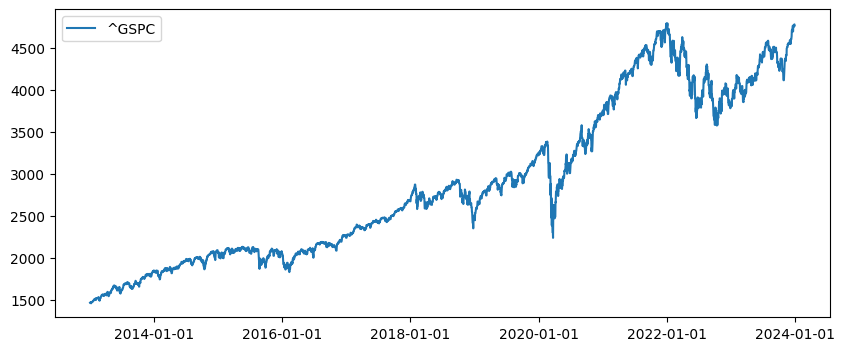

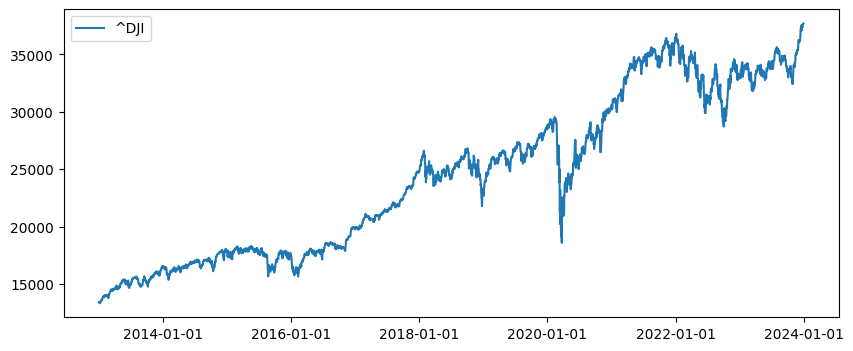

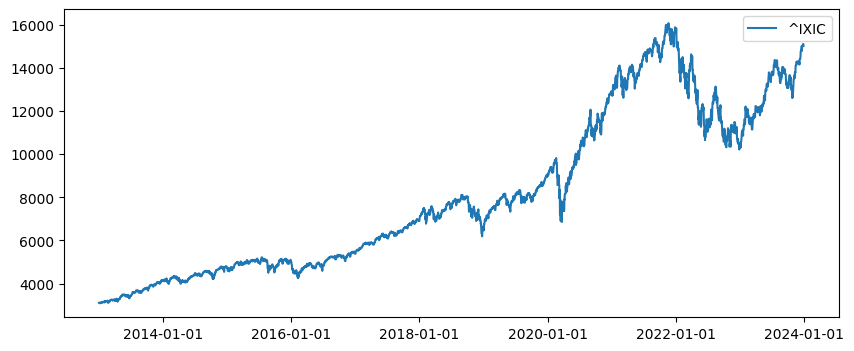

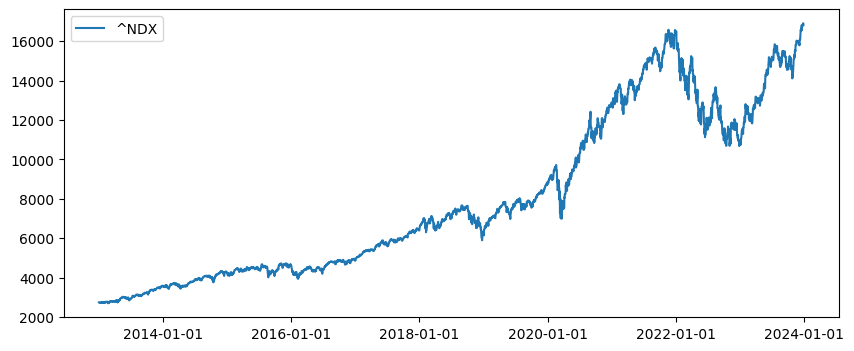

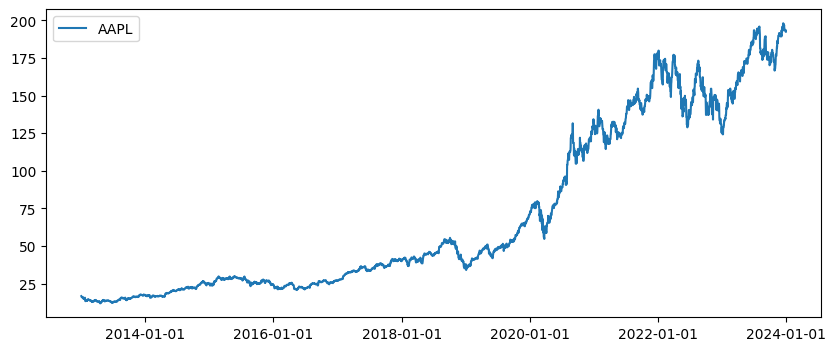

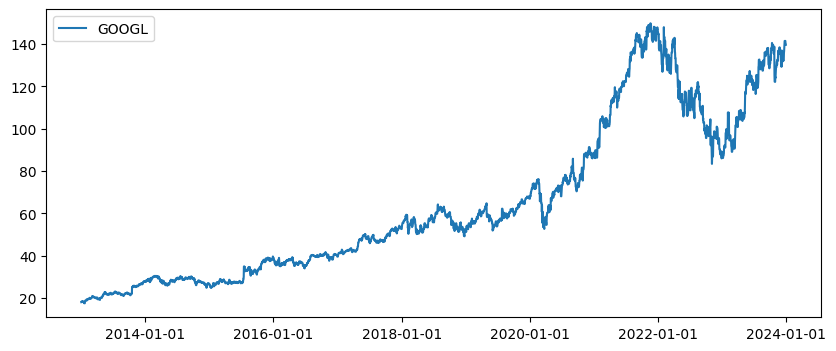

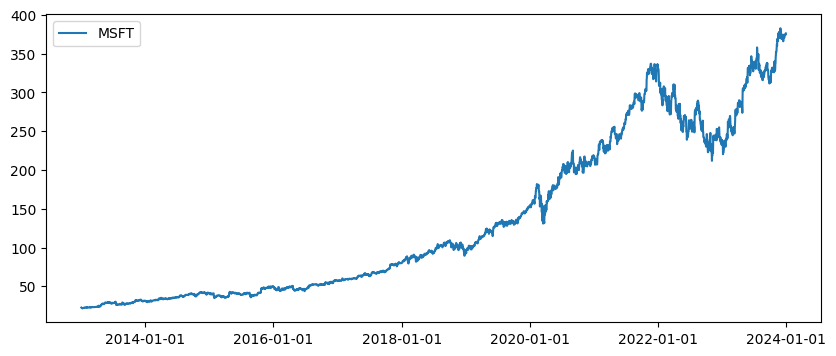

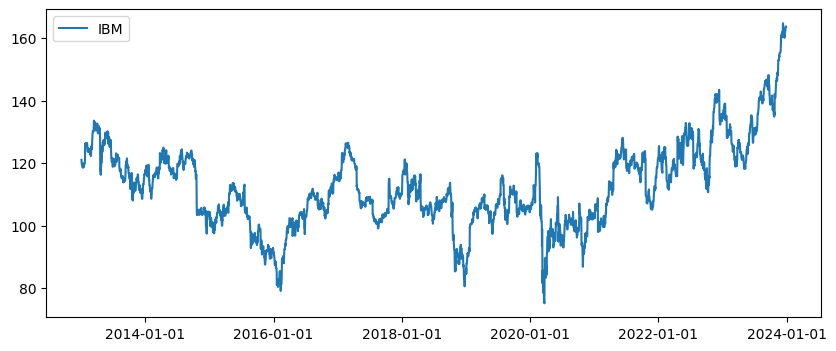

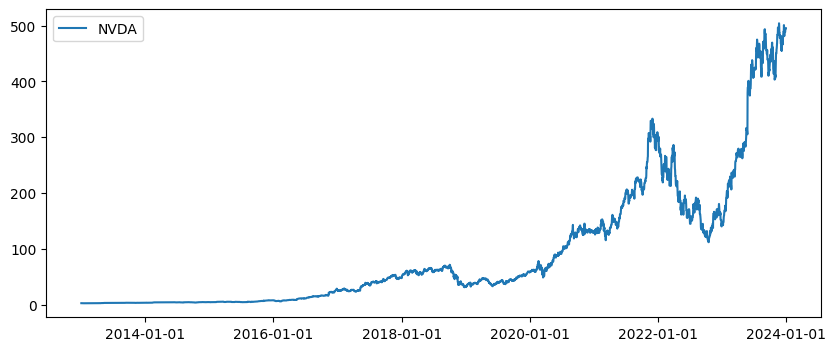

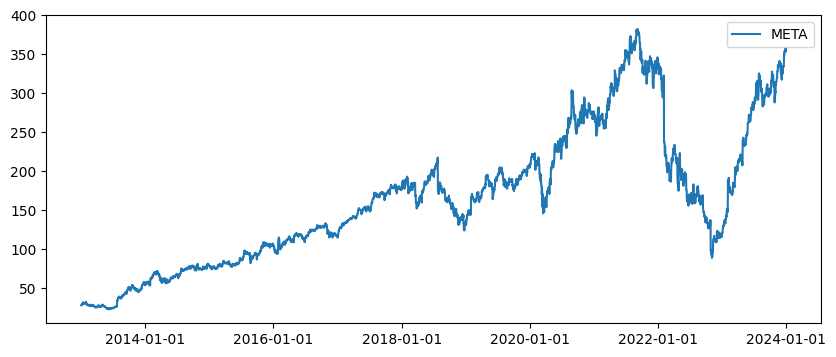

In [18]:
plot_time_series(data)

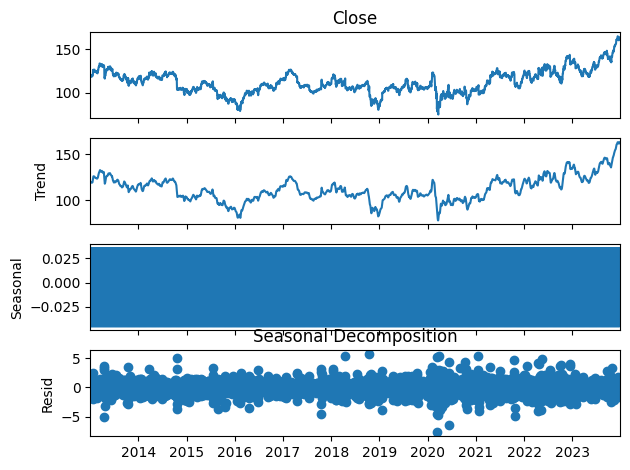

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

seasonal_decompose_result = seasonal_decompose(data['IBM'])
seasonal_decompose_result.plot()
plt.title(f'Seasonal Decomposition')
plt.show()

### visualization tests

## time range selection

In [20]:
data['IBM_3Y'] = data['IBM'].iloc[-365*3:]

In [21]:
data_ibm = data['IBM_3Y']

In [22]:
# set time frequency
print(data_ibm.index.freq)
data_ibm.index.freq = 'D' # Set the frequency to daily
print(data_ibm.index.freq)

None
<Day>


## Hypothesis testing: stationary data

We will observe and test the data to discover if it's stationary or not by:  
a) visual tests  
b) summary statistics by partition  
c) statistical tests  
    -- Dickey-Fuller (DF) test   
    -- Kwiatkowski-Phillips-Schmidt-Shin (KPSS)  

### Dickey-Fuller Test

Dickey-Fuller Test
The Dickey-Fuller (DF) test was developed and popularized by Dickey and Fuller (1979). The null hypothesis of DF test is that there is a unit root in an AR model, which implies that the data series is not stationary. The alternative hypothesis is generally stationarity or trend stationarity but can be different depending on the version of the test is being used.

Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

parameters:  
“c” : constant only (default).
“ct” : constant and trend.
“ctt” : constant, and linear and quadratic trend.
“n” : no constant, no trend.


In [1]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def adf_test(dict):
    results = []
    for ticker, series in dict.items():
        adfuller_test = adfuller(
            series,
            maxlag=None, 
            regression='c', 
            autolag='AIC', 
            store=False, 
            regresults=False)

        result = {
            'ticker': ticker,
            'ADF Statistic': adfuller_test[0],
            'p-value': adfuller_test[1],
            'used_lag': adfuller_test[2],
            'nobs': adfuller_test[3]
        }

        for key, value in adfuller_test[4].items():
            result[f'Critical Value {key}'] = value

        results.append(result)

    return pd.DataFrame(results)


In [2]:
adf_panel_results = adf_test(data)

NameError: name 'adf_test' is not defined

In [25]:
adf_panel_results

,ticker,ADF Statistic,p-value,used_lag,nobs,Critical Value 1%,Critical Value 5%,Critical Value 10%
0,^GSPC,-0.345935,0.918742,20,3993,-3.431989,-2.862264,-2.567155
1,^DJI,-0.624802,0.865279,23,3990,-3.431990,-2.862265,-2.567156
2,^IXIC,-0.323742,0.922074,20,3993,-3.431989,-2.862264,-2.567155
3,^NDX,0.198602,0.972183,20,3993,-3.431989,-2.862264,-2.567155
4,AAPL,0.503555,0.984981,26,3987,-3.431991,-2.862265,-2.567156
5,GOOGL,0.157475,0.969773,31,3982,-3.431993,-2.862266,-2.567157
6,MSFT,1.247725,0.996300,27,3986,-3.431992,-2.862265,-2.567156
7,IBM,-2.079514,0.252832,13,4000,-3.431986,-2.862263,-2.567155
8,NVDA,2.136038,0.998826,31,3982,-3.431993,-2.862266,-2.567157
9,META,-0.703375,0.845873,16,3997,-3.431987,-2.862263,-2.567155


Null - hypothesis:  
No reason found to reject the null hypothesis found as the p-value is greater than the significance level  
therefore this test assumes the data is non-stationary

### KPSS test

The KPSS test, short for, Kwiatkowski-Phillips-Schmidt-Shin (KPSS), is a type of Unit root test that tests for the stationarity of a given series around a deterministic trend. In other words, the test is somewhat similar in spirit to the ADF test. A common misconception, however, is that it can be used interchangeably with the ADF test. This can lead to misinterpretations about stationarity, which can easily go undetected, causing more problems down the line.  
source: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#:~:text=That%20is%2C%20if%20the%20p%2Dvalue%20is%20%3C%20significance%20level,the%20tested%20series%20is%20stationary.

In [26]:
from statsmodels.tsa.stattools import kpss
import pandas as pd

def kpss_test(dict):
    results = []
    for ticker, series in dict.items():
        kpss_test = kpss(
            series,
            regression='c', 
            nlags='auto', 
            store=False)

        result = {
            'ticker': ticker,
            'KPSS Statistic': kpss_test[0],
            'p-value': kpss_test[1],
            'used_lag': kpss_test[2]
        }

        results.append(result)

    return pd.DataFrame(results)


In [27]:
kpss_panel_results = kpss_test(data)
kpss_panel_results

/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_50121/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_50121/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_50121/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(
/var/folders/sf/w99qq72n7ld5cplb4kcgbmxm0000gn/T/ipykernel_50121/4046930886.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. Th

,ticker,KPSS Statistic,p-value,used_lag
0,^GSPC,9.489351,0.01,39
1,^DJI,9.717518,0.01,39
2,^IXIC,9.213111,0.01,39
3,^NDX,9.298403,0.01,39
4,AAPL,8.931876,0.01,39
5,GOOGL,8.889316,0.01,39
6,MSFT,9.323887,0.01,39
7,IBM,2.108312,0.01,39
8,NVDA,7.062088,0.01,39
9,META,7.473362,0.01,39


### other links

info:  
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html  
https://pandas.pydata.org/docs/reference/api/pandas.Series.autocorr.html  
post predictions:  
https://www.investopedia.com/terms/d/durbin-watson-statistic.asp  
https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html (residuals)


### autocorrelation (non-stationary data)

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def autocorr_plots(df_dict):
    for ticker, df in df_dict.items():
        fig, ax = plt.subplots(figsize=(6, 3))
        pd.plotting.autocorrelation_plot(df, ax=ax)
        plt.title(f'Autocorrelation Plot for {ticker}')
        plt.show()


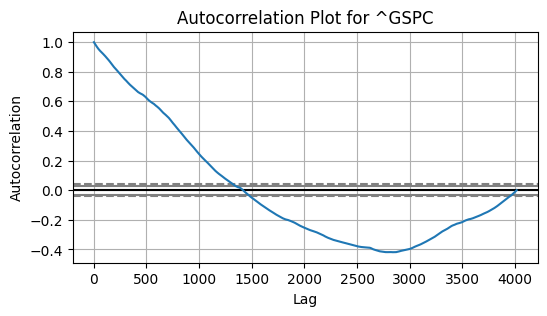

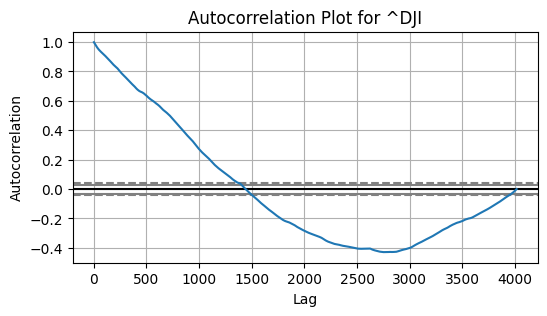

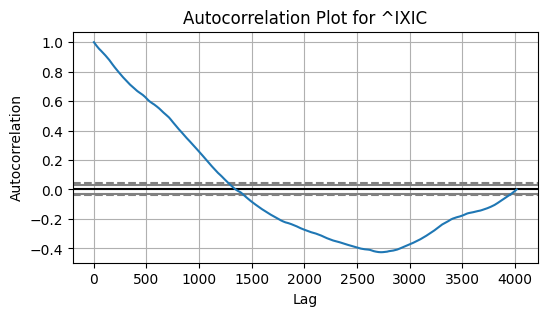

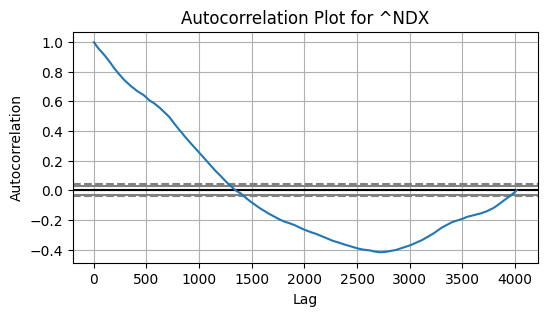

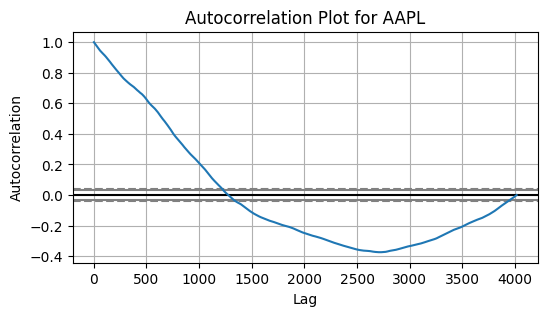

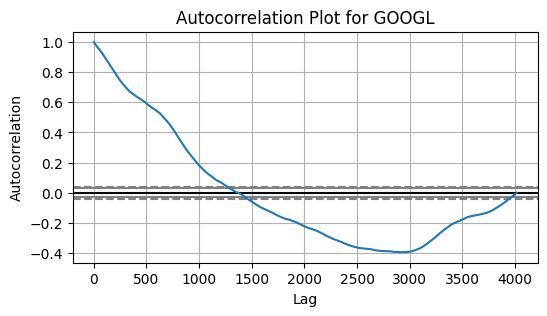

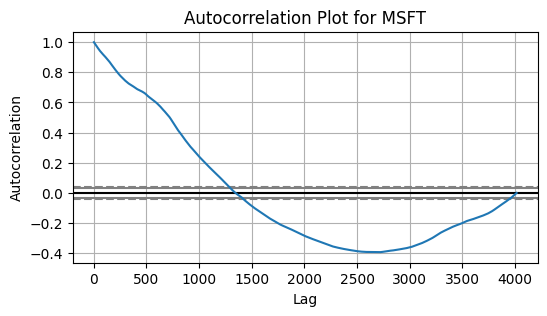

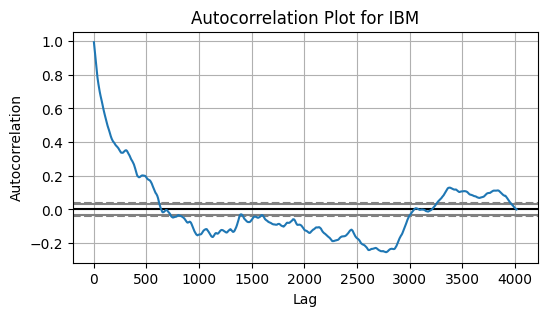

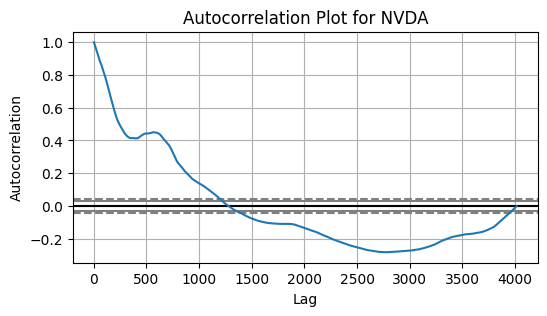

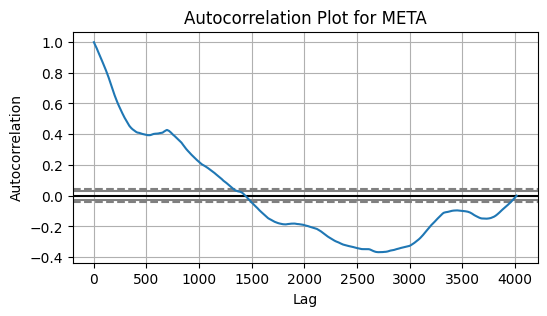

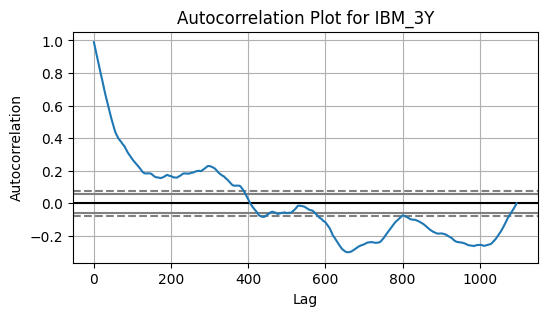

In [29]:
autocorr_plots(data)

correlation check ideas:  
Autocorrelation Function (ACF): The ACF plot can help identify seasonality. If there is significant seasonality, the ACF plot should show spikes at lags equal to the period.  
Statistical Tests: There are formal hypothesis tests available to detect seasonality, such as the Student T-Test and the Wilcoxon Signed Rank Test. These tests can be used to check if the observed seasonality is statistically significant.

In [30]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_acfs(stock_dict):
    for item, series in stock_dict.items():
        print(f"Plotting ACF for {item}")
        plot_acf(series)
        plt.show()


Plotting ACF for ^GSPC


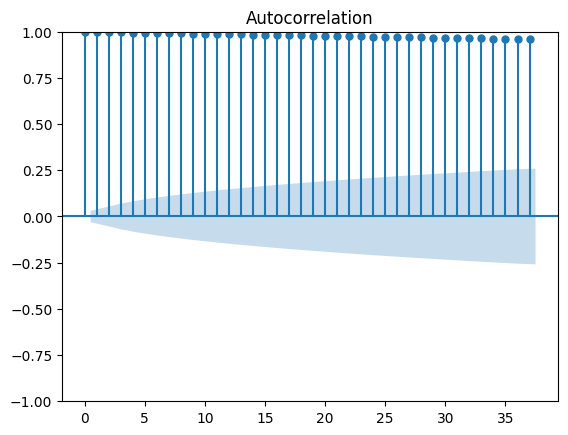

Plotting ACF for ^DJI


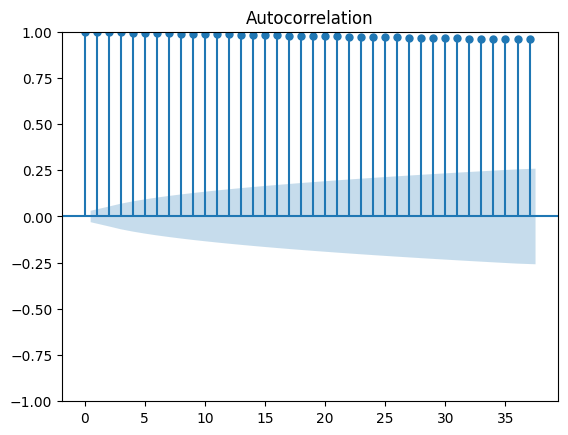

Plotting ACF for ^IXIC


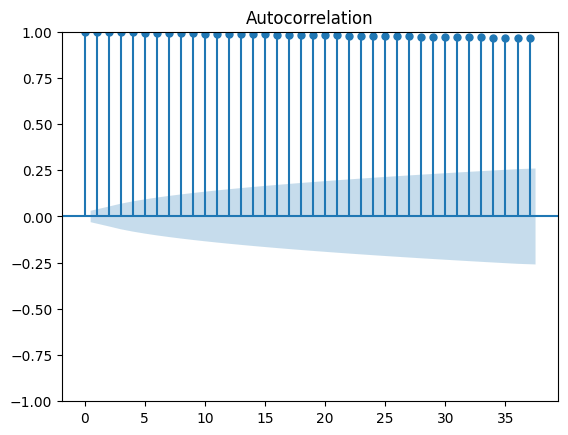

Plotting ACF for ^NDX


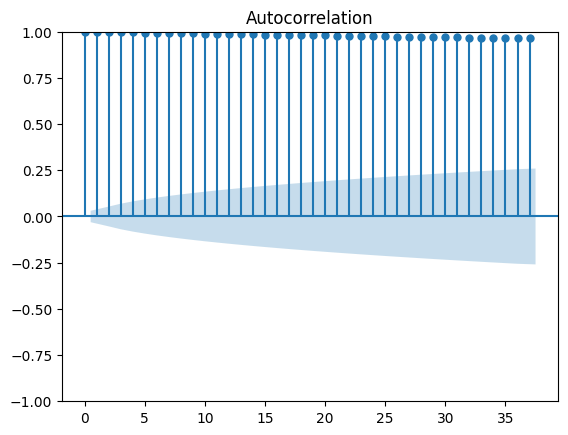

Plotting ACF for AAPL


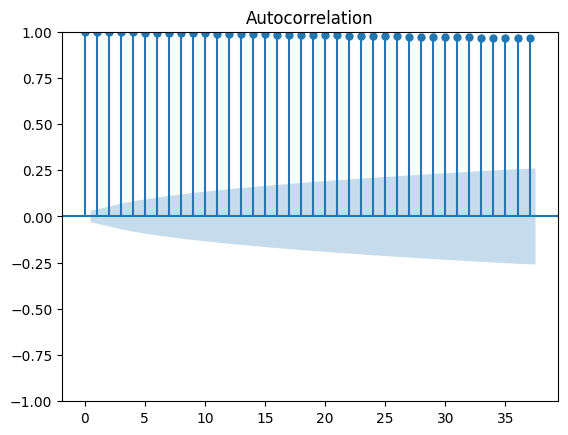

Plotting ACF for GOOGL


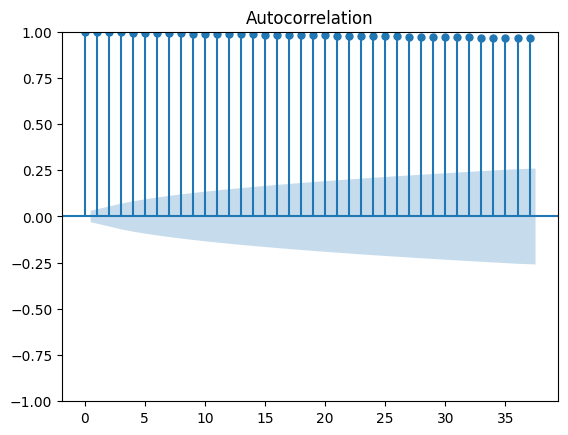

Plotting ACF for MSFT


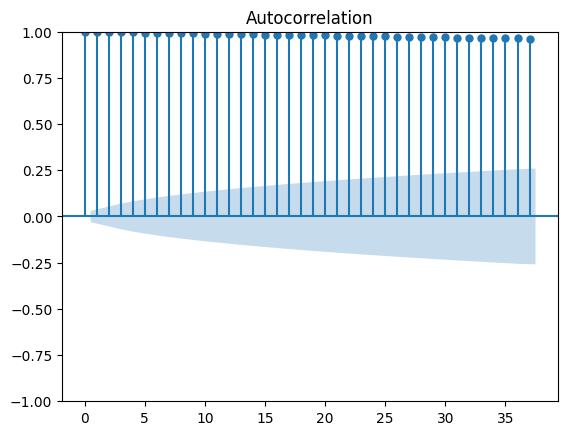

Plotting ACF for IBM


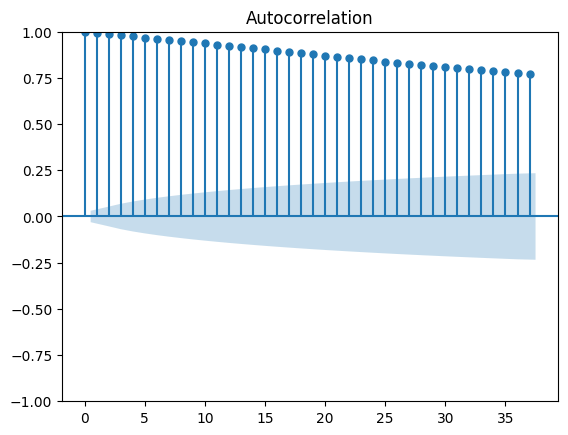

Plotting ACF for NVDA


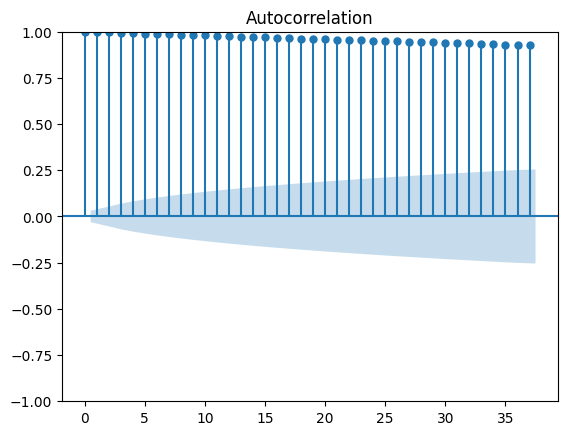

Plotting ACF for META


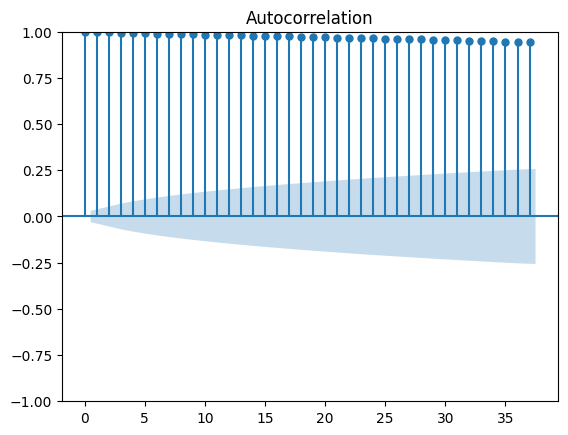

Plotting ACF for IBM_3Y


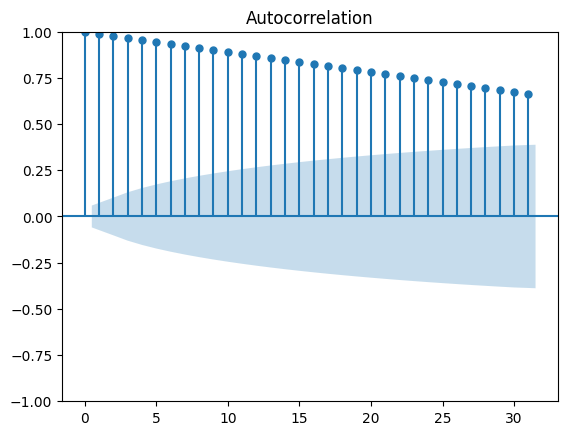

In [31]:
plot_acfs(data)

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf

def plot_pacfs(stock_dict):
    for item, series in stock_dict.items():
        print(f"Plotting PACF for {item}")
        plot_pacf(series)
        plt.show()


Plotting PACF for ^GSPC


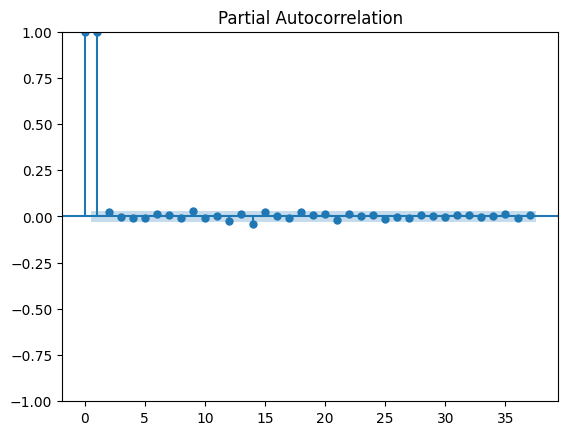

Plotting PACF for ^DJI


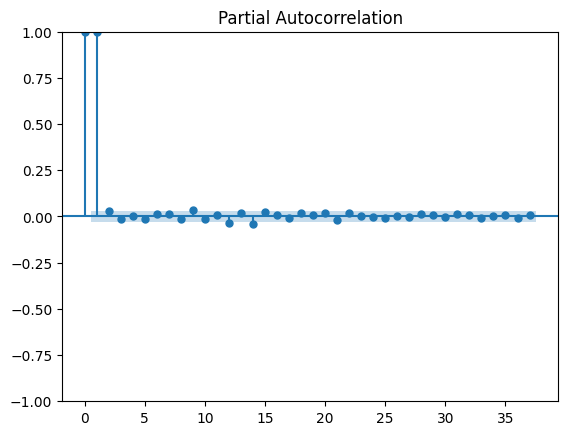

Plotting PACF for ^IXIC


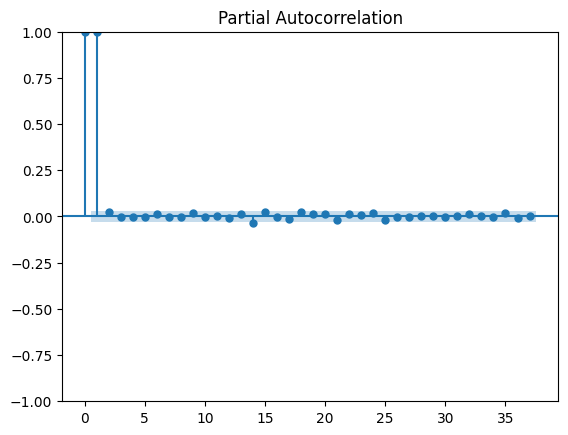

Plotting PACF for ^NDX


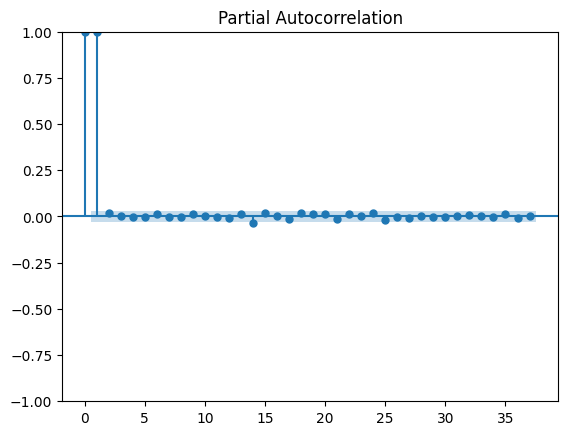

Plotting PACF for AAPL


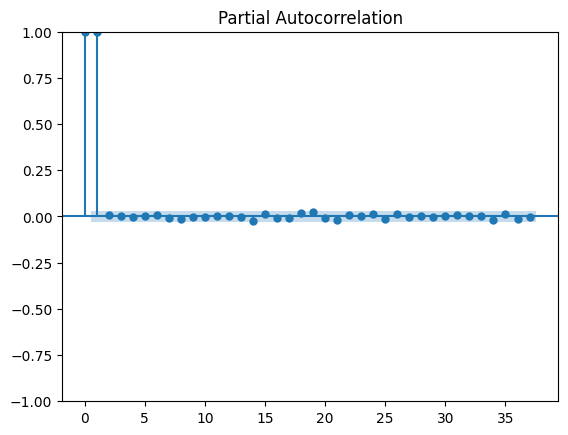

Plotting PACF for GOOGL


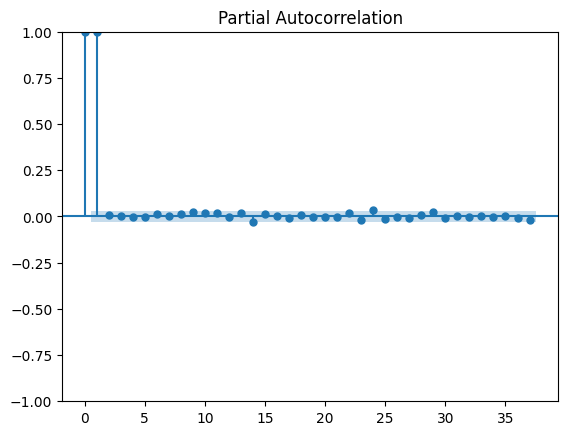

Plotting PACF for MSFT


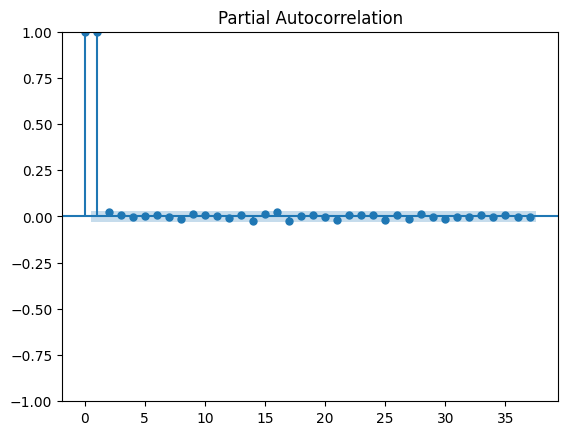

Plotting PACF for IBM


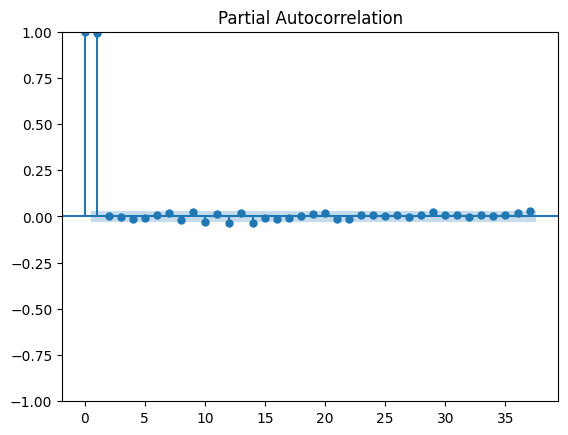

Plotting PACF for NVDA


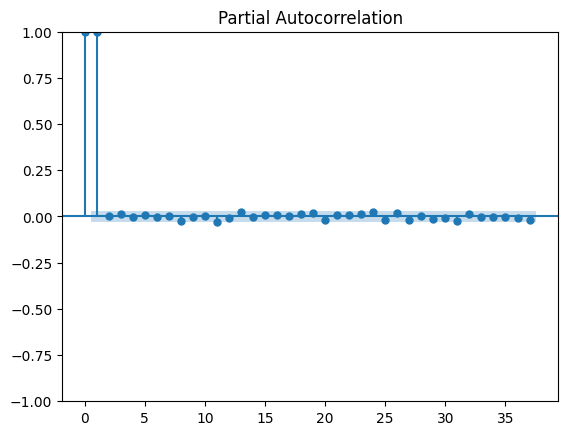

Plotting PACF for META


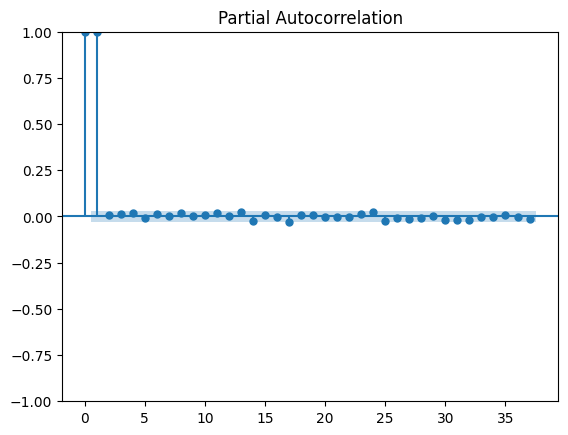

Plotting PACF for IBM_3Y


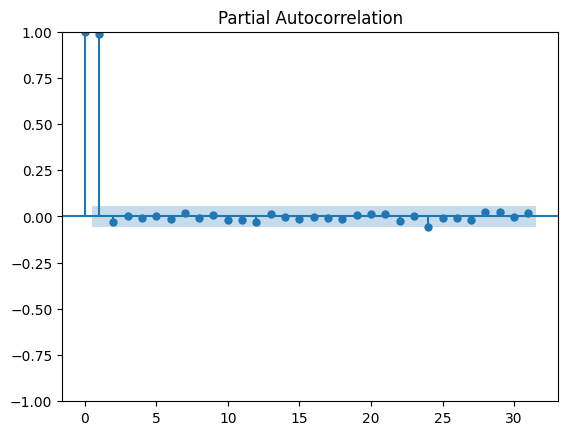

In [33]:
plot_pacfs(data)

## Train / Test Split --> Start "data" for testing

### temporal split

In [34]:
#data_ibm

In [35]:
data_ibm.index.freq, #y_transformed.index.freq,

(<Day>,)

In [36]:
#data_ibm.index.freq = 'D' # Set the frequency to daily

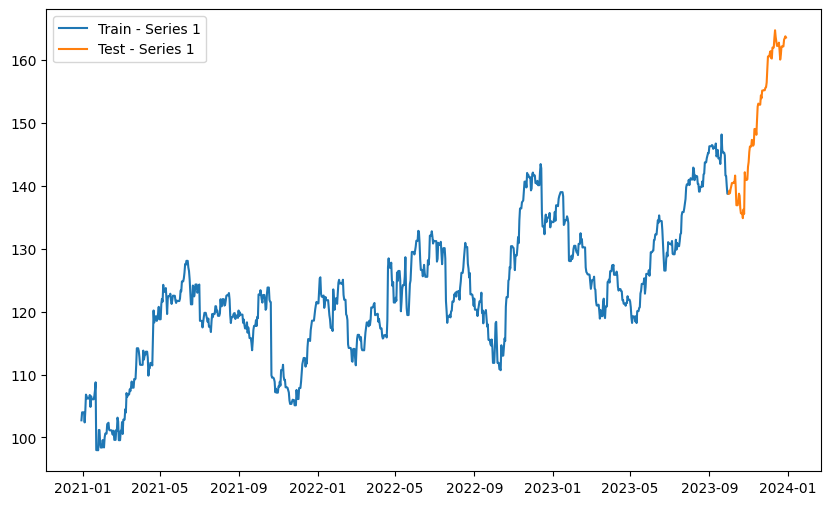

(2023-09-28    139.992325
 2023-09-29    138.726685
 2023-09-30    138.726685
 Freq: D, Name: Close, dtype: float64,
 2023-10-01    138.726685
 2023-10-02    139.221085
 2023-10-03    138.815674
 Freq: D, Name: Close, dtype: float64)

In [37]:
import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split

#y_train, y_test = temporal_train_test_split(y_transformed, test_size=90)
y_train, y_test = temporal_train_test_split(data_ibm, test_size=90)

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
#plt.plot(data_ibm, label='all')

plt.legend()
plt.show()

y_train.tail(3), y_test.head(3)

In [38]:
y_train.index.freq, y_test.index.freq,

(<Day>, <Day>)

## Converting non - stationary data to stationary. 
differencing, log transformation, or a Box-Cox transformation. 

Statistical stationarity: A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. Most statistical forecasting methods are based on the assumption that the time series can be rendered approximately stationary (i.e., "stationarized") through the use of mathematical transformations. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past!   (Recall our famous forecasting quotes.)  The predictions for the stationarized series can then be "untransformed," by reversing whatever mathematical transformations were previously used, to obtain predictions for the original series. (The details are normally taken care of by your software.) Thus, finding the sequence of transformations needed to stationarize a time series often provides important clues in the search for an appropriate forecasting model.  Stationarizing a time series through differencing (where needed) is an important part of the process of fitting an ARIMA model, as discussed in the ARIMA pages of these notes.

Another reason for trying to stationarize a time series is to be able to obtain meaningful sample statistics such as means, variances, and correlations with other variables. Such statistics are useful as descriptors of future behavior only if the series is stationary. For example, if the series is consistently increasing over time, the sample mean and variance will grow with the size of the sample, and they will always underestimate the mean and variance in future periods. And if the mean and variance of a series are not well-defined, then neither are its correlations with other variables. For this reason you should be cautious about trying to extrapolate regression models fitted to nonstationary data.

Most business and economic time series are far from stationary when expressed in their original units of measurement, and even after deflation or seasonal adjustment they will typically still exhibit trends, cycles, random-walking, and other non-stationary behavior.   If the series has a stable long-run trend and tends to revert to the trend line following a disturbance, it may be possible to stationarize it by de-trending (e.g., by fitting a trend line and subtracting it out prior to fitting a model, or else by including the time index as an independent variable in a regression or ARIMA model), perhaps in conjunction with logging or deflating.   Such a series is said to be trend-stationary.    However, sometimes even de-trending is not sufficient to make the series stationary, in which case it may be necessary to transform it into a series of period-to-period and/or season-to-season differences.  If the mean, variance, and autocorrelations of the original series are not constant in time, even after detrending, perhaps the statistics of the changes in the series between periods or between seasons will be constant.   Such a series is said to be difference-stationary.  (Sometimes it can be hard to tell the difference between a series that is trend-stationary and one that is difference-stationary, and a so-called unit root test may be used to get a more definitive answer.  We will return to this topic later in the course.)
(Return to top of page.)
source: https://people.duke.edu/~rnau/411diff.htm

In [39]:
from sktime.transformations.series.difference import Differencer

# Initialize the differencer
differencer = Differencer(lags=1, na_handling='fill_zero', memory='all') # Adjust the lags according to your needs

# Fit the differencer on the training data
differencer.fit(y_train)
#differencer.fit(data_ibm)

# Transform the training data
train_transformed = differencer.transform(y_train)

# Now, apply the same differencer to the testing data -- not needed for time series?
#test_transformed = differencer.transform(y_test)

#remove?
#y_transformed = differencer.transform(data_ibm)
#y_transformed_copy = y_transformed.copy() # needed?

#y_original = differencer.inverse_transform(y_transformed)




### transformation checks

In [40]:
data_ibm.index.freq, y_train.index.freq, train_transformed.index.freq

(<Day>, <Day>, <Day>)

In [41]:
y_train.head(5), train_transformed.head(5)# ,data_ibm.tail(5), y_original.tail(5)

(2020-12-30    102.727783
 2020-12-31    104.000092
 2021-01-01    104.000092
 2021-01-02    104.000092
 2021-01-03    104.000092
 Freq: D, Name: Close, dtype: float64,
 2020-12-30    0.000000
 2020-12-31    1.272308
 2021-01-01    0.000000
 2021-01-02    0.000000
 2021-01-03    0.000000
 Freq: D, Name: Close, dtype: float64)

In [42]:
y_train.tail(5), train_transformed.tail(5)# ,data_ibm.tail(5), y_original.tail(5)

(2023-09-26    141.633713
 2023-09-27    141.564499
 2023-09-28    139.992325
 2023-09-29    138.726685
 2023-09-30    138.726685
 Freq: D, Name: Close, dtype: float64,
 2023-09-26   -3.203659
 2023-09-27   -0.069214
 2023-09-28   -1.572174
 2023-09-29   -1.265640
 2023-09-30    0.000000
 Freq: D, Name: Close, dtype: float64)

In [43]:
train_transformed.describe()

count    1005.000000
mean        0.035820
std         1.361759
min       -11.620338
25%        -0.372139
50%         0.000000
75%         0.567123
max         8.423592
Name: Close, dtype: float64

In [44]:
# check errors not working with latest data
#adf_panel_results = adf_test(train_transformed)
#adf_panel_results

### Visualization on stationary data - check differencing

In [45]:
#plot_time_series(train_transformed)

In [46]:
#autocorr_plots(train_transformed)

In [47]:
#plot_acfs(train_transformed)

In [48]:
#plot_pacfs(train_transformed)

## Evaluation Metrics functions:

In [49]:
# create new model scoring dataframe to save scores:

model_scoring = pd.DataFrame({
    'Model': [],
    'RMSE': [],
    'MAE': [],
    'MAPE': []
})


In [50]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd

def calculate_error_metrics(model_name, y_test, y_pred):
    # Calculate the errors
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Create a DataFrame with the results
    df = pd.DataFrame({
        'Model': [model_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape]
    })
    #scoring_df = scoring_df.append(df, ignore_index=True)
    #scoring_df = scoring_df.append(df, ignore_index=True)

    #display(df)
    
    return df


In [297]:
from sktime.performance_metrics.forecasting import MeanSquaredError
import numpy as np

class RootMeanSquaredError_(MeanSquaredError):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def score(self, y_true, y_pred):
        mse = super().score(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse


In [51]:
#y_test.describe()

In [52]:
#y_pred.describe()

In [53]:
#calculate_errors('model', y_test, y_pred)

RMSE MAE MAPE ME MPE

In [54]:
# evaluate (?)

## Model building part i: classic statistics

For example, in python and R, the auto ARIMA method itself will generate the optimal p and q parameters, which would be suitable for the data set to provide better forecasting. The high-level logic behind that is the same as the logic behind hyperparameter tuning of any other machine learning model. We need to try some combinations of p and q parameters and compare results using a validation set.

Since our search space is not big, usually values p and q are not higher than 10, we can apply a popular technique for hyperparameter optimization called grid search. Grid search is simply an exhaustive search through a manually specified subset of the hyperparameter space of a learning algorithm. Basically, it means that this method will try each combination of p and q from the specified subset that we provided.  
source: https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling#:~:text=The%20autocorrelation%20function%20(ACF)%20is,number%20of%20periods%20or%20units.

In [55]:
# ARIMA + gridearch SARIMA?

In [56]:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [57]:
# check multiple train test splits from sktime!
#https://towardsdatascience.com/build-complex-time-series-regression-pipelines-with-sktime-910bc25c96b6

In [58]:
predictions_df = pd.DataFrame(index=y_test.index)
#predictions_df = pd.concat([predictions_df, y_test], axis=1)
predictions_df['y_test'] = y_test.values
predictions_df.head()

,y_test
2023-10-01,138.726685
2023-10-02,139.221085
2023-10-03,138.815674
2023-10-04,139.488052
2023-10-05,139.932999


### (t0) simple moving average model (SMA) using sktime naive forecaster + gridsearch

In [327]:
# with grid search:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

param_grid = {
    'window_length': [2, 3, 5, 9, 10, 15, 20, 30]
}

cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

model = NaiveForecaster(strategy='mean', sp=1) #Seasonal periodicity to use in the seasonal forecasting. None=1.

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(y_train)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = grid_search.predict(fh_n)
#y_original = differencer.inverse_transform(y_transformed)

# Access the cross-validation results
cv_results = grid_search.cv_results_
cv_results

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.049893,0.001173,0.001606,{'window_length': 2},2.0
1,0.049878,0.001106,0.001457,{'window_length': 3},1.0
2,0.049950,0.001058,0.001390,{'window_length': 5},3.0
3,0.050524,0.001132,0.001701,{'window_length': 9},4.0
4,0.050782,0.001182,0.001586,{'window_length': 10},5.0
5,0.051660,0.001145,0.001581,{'window_length': 15},6.0
6,0.053053,0.001224,0.001516,{'window_length': 20},7.0
7,0.055575,0.001144,0.001440,{'window_length': 30},8.0


In [329]:
# error metrics:
model_name = 'SMA_gscv_win3_t0'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
#model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
#model_scoring

,Model,RMSE,MAE,MAPE
0,SMA_gscv_win3_t0,15.000758,12.049256,0.076594


In [211]:
# testing; drop col
#model_scoring.drop(index=10, inplace=True)
#model_scoring

In [62]:
#type(y_pred)
y_pred.index.freq
#diff_data_ibm.index.freq = 'D' # Set the frequency to daily


<Day>

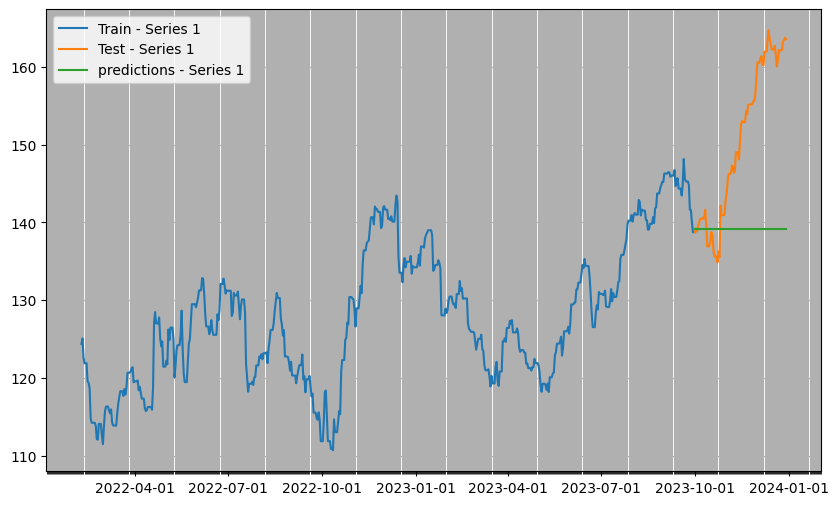

In [330]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(y_train.iloc[-600:].index, y_train.iloc[-600:], label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
plt.plot(y_pred.index, y_pred, label='predictions - Series 1')

# Format x-axis to display dates
ax = plt.gca()
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Add gridlines for each day
ax = plt.gca()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(True, which='both')

plt.legend()
plt.show()

print(y_pred.iloc[0])

In [64]:
# also add evaluate -=-

### (t1) simple moving average model (SMA) using sktime naive forecaster + gridsearch

In [65]:
# with grid search:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

param_grid = {
    'window_length': [2, 3, 5, 9, 10, 15, 20, 30]
}

cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

model = NaiveForecaster(strategy='mean', sp=1) #Seasonal periodicity to use in the seasonal forecasting. None=1.

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(train_transformed)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = grid_search.predict(fh_n)

y_pred = differencer.inverse_transform(y_pred_transformed)

# Access the cross-validation results
cv_results = grid_search.cv_results_
cv_results

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/sktime/forecasting/model_selection/_tune.py:201: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.27.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(


{'window_length': 30}


,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,1.144229e+15,0.001152,0.001528,{'window_length': 2},8.0
1,9.105946e+14,0.001116,0.001533,{'window_length': 3},7.0
2,6.961257e+14,0.001222,0.001501,{'window_length': 5},6.0
3,5.635127e+14,0.001188,0.001802,{'window_length': 9},5.0
4,5.405826e+14,0.001144,0.001613,{'window_length': 10},4.0
5,3.907758e+14,0.001312,0.001576,{'window_length': 15},3.0
6,3.670140e+14,0.001154,0.001494,{'window_length': 20},2.0
7,2.791677e+14,0.001171,0.001511,{'window_length': 30},1.0


In [66]:
# error metrics:
model_name = 'SMA_gscv_win30_t1'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

,Model,RMSE,MAE,MAPE
0,SMA_gscv_win3_t0,15.000758,12.049256,0.076594
1,SMA_gscv_win30_t1,26.394814,21.503861,0.136863


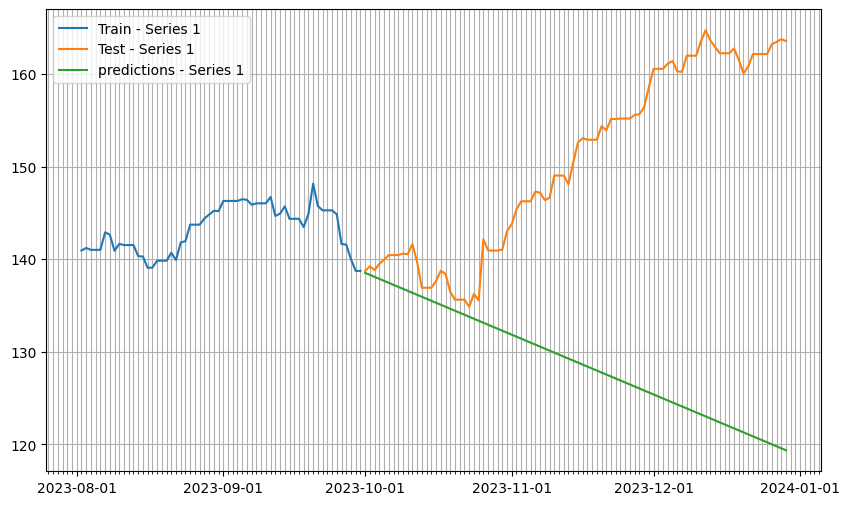

138.51145884195964


In [67]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(y_train.iloc[-60:].index, y_train.iloc[-60:], label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
plt.plot(y_pred.index, y_pred, label='predictions - Series 1')

# Format x-axis to display dates
ax = plt.gca()
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Add gridlines for each day
ax = plt.gca()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(True, which='both')

plt.legend()
plt.show()

print(y_pred.iloc[0])

### t(0) simple exponential smoothing (SES) * gridsearch 

In [73]:
# with grid search:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'sp': [365, 12, 1, 2], #4, 6, 8
    'smoothing_level': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'smoothing_trend': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'smoothing_seasonal': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'damping_trend': [0.5, 0.6, 0.7, 0.8, 0.9]
}
#'sp': [365, 12, 1, 2] #4, 6, 8
param_grid = {
    'trend': ['add', 'mul', None],
    'damped_trend': [True, False],
    'sp': [365, 12, 1, 2]
    #'smoothing_level': [0.0, 0.2, 0.5,]
}
cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

model = ExponentialSmoothing() #(can use box-cox).

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(y_train)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = grid_search.predict(fh_n)

# Access the cross-validation results
cv_results = grid_search.cv_results_
cv_results

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/sktime/forecasting/model_selection/_tune.py:201: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.27.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(
/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/sktime/utils/parallel.py:92: FitFailedWarning: 
                In evaluate, fitting of forecaster ExponentialSmoothing failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=30.
                The score will be set to nan.
                Failed forecaster with parameters: ExponentialSmoothing(damped_trend=True, sp=365).
                
  ret = [fun(x

{'damped_trend': False, 'sp': 365, 'trend': None}


,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.059956,0.008088,0.003327,"{'damped_trend': True, 'sp': 365, 'trend': 'add'}",6.5
1,0.127307,0.010440,0.003444,"{'damped_trend': True, 'sp': 365, 'trend': 'mul'}",18.5
2,NaN,NaN,NaN,"{'damped_trend': True, 'sp': 365, 'trend': None}",NaN
3,0.059956,0.008001,0.003341,"{'damped_trend': True, 'sp': 12, 'trend': 'add'}",6.5
4,0.127307,0.010514,0.003444,"{'damped_trend': True, 'sp': 12, 'trend': 'mul'}",18.5
5,NaN,NaN,NaN,"{'damped_trend': True, 'sp': 12, 'trend': None}",NaN
6,0.059956,0.007916,0.003285,"{'damped_trend': True, 'sp': 1, 'trend': 'add'}",6.5
7,0.127307,0.010846,0.003408,"{'damped_trend': True, 'sp': 1, 'trend': 'mul'}",18.5
8,NaN,NaN,NaN,"{'damped_trend': True, 'sp': 1, 'trend': None}",NaN
9,0.059956,0.008471,0.003263,"{'damped_trend': True, 'sp': 2, 'trend': 'add'}",6.5


In [74]:
# error metrics:
model_name = 'SES_gscv_damp0_trend0_sp365_t0'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

,Model,RMSE,MAE,MAPE
0,SMA_gscv_win3_t0,15.000758,12.049256,0.076594
1,SMA_gscv_win30_t1,26.394814,21.503861,0.136863
2,SES_gscv_damp0_trend0_s5_t0,14.848146,11.916442,0.075752
3,SES_gscv_damp0_trend0_t0,15.320774,12.332927,0.078400
4,SES_gscv_damp0_trend0_sp365_t0,15.320774,12.332927,0.078400


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(y_train.iloc[-30:].index, y_train.iloc[-30:], label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
plt.plot(y_pred.index, y_pred, label='predictions - Series 1')

# Format x-axis to display dates
ax = plt.gca()
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Add gridlines for each day
ax = plt.gca()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(True, which='both')

plt.legend()
plt.show()

print(y_pred.iloc[0])

In [ ]:
# also add evaluate -=-

### t(1) simple exponential smoothing (SES) * gridsearch 

In [355]:
# with grid search:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'sp': [365, 12, 1, 2], #4, 6, 8
    'smoothing_level': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'smoothing_trend': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'smoothing_seasonal': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'damping_trend': [0.5, 0.6, 0.7, 0.8, 0.9]
}
#'sp': [365, 12, 1, 2] #4, 6, 8
param_grid = {
    'smoothing_level': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}
cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

model = ExponentialSmoothing() #(can use box-cox).

grid_search = ForecastingGridSearchCV(forecaster=model, param_grid=param_grid, cv=cv)

grid_search.fit(train_transformed)

best_params = grid_search.best_params_

print(best_params)

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = grid_search.predict(fh_n)

y_pred = differencer.inverse_transform(y_pred_transformed)

# Access the cross-validation results
cv_results = grid_search.cv_results_
cv_results


,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,2.791677e+14,0.002839,0.003096,{'smoothing_level': 0.0},1.0
1,3.795900e+14,0.003189,0.002911,{'smoothing_level': 0.1},2.0
2,5.608205e+14,0.002935,0.003080,{'smoothing_level': 0.2},3.0
3,7.154567e+14,0.003112,0.003444,{'smoothing_level': 0.3},4.0
4,8.527798e+14,0.002977,0.003387,{'smoothing_level': 0.4},5.0
5,9.793183e+14,0.002892,0.002951,{'smoothing_level': 0.5},6.0
6,1.102044e+15,0.002817,0.002971,{'smoothing_level': 0.6},7.0
7,1.228217e+15,0.003039,0.003040,{'smoothing_level': 0.7},8.0
8,1.373879e+15,0.001638,0.001627,{'smoothing_level': 0.8},9.0
9,1.519380e+15,0.001452,0.001829,{'smoothing_level': 0.9},10.0


In [356]:
print(grid_search.best_params_)

In [357]:
# error metrics:
model_name = 'SES_gscv_s0_t1'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result
#model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
#model_scoring

,Model,RMSE,MAE,MAPE
0,SES_gscv_s0_t1,13.5103,10.900504,0.069356


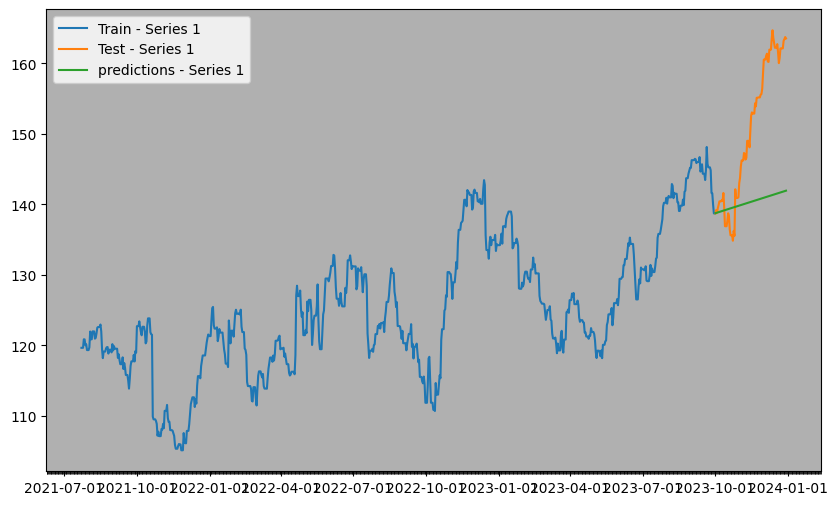

In [358]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(y_train.iloc[-800:].index, y_train.iloc[-800:], label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
plt.plot(y_pred.index, y_pred, label='predictions - Series 1')

# Format x-axis to display dates
ax = plt.gca()
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Add gridlines for each day
ax = plt.gca()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(True, which='both')

plt.legend()
plt.show()

print(y_pred.iloc[0])

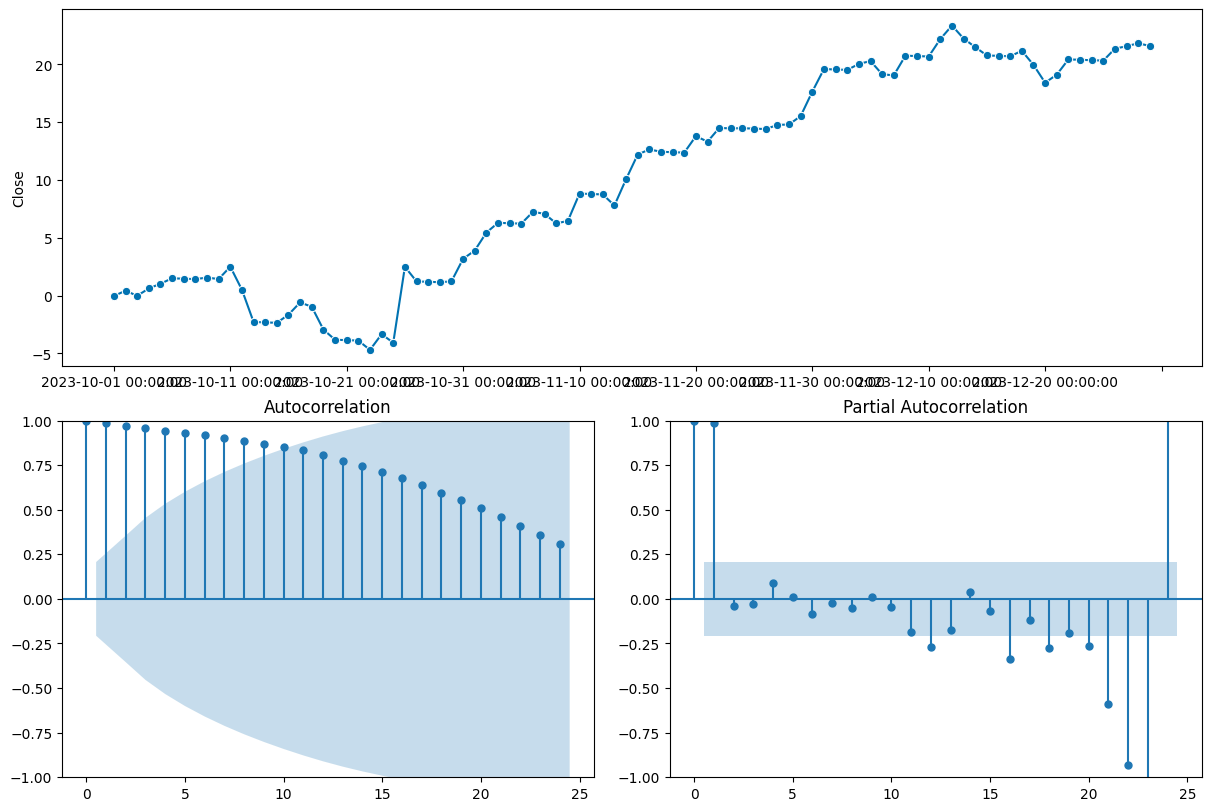

In [360]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()


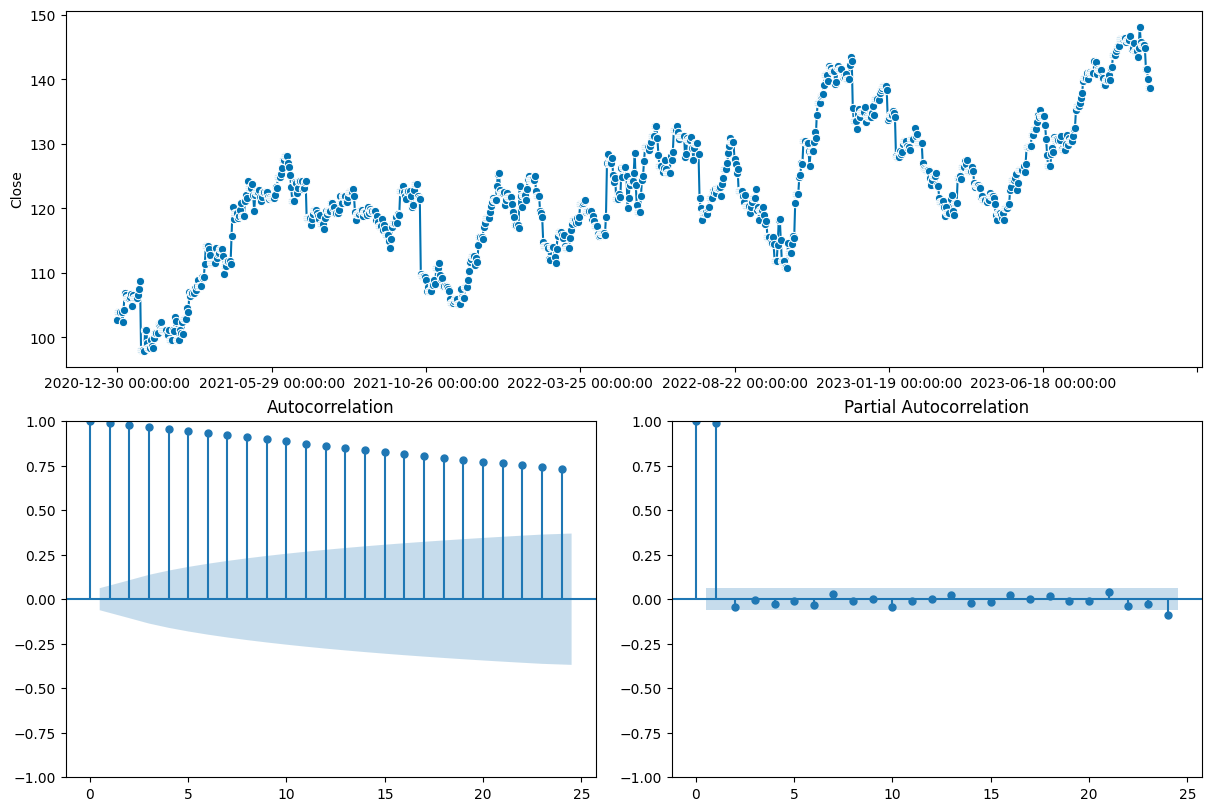

In [353]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(y_train)
plt.show()


  
  Testing with parameters  
    

In [101]:
# testing
model = ExponentialSmoothing(smoothing_level=0.9999) #(can use box-cox).
model.fit(train_transformed)
fh_n = ForecastingHorizon(y_test.index, is_relative=False)
y_pred_transformed = model.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

model_name = 'SES_gscv_sn_t1'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

,Model,RMSE,MAE,MAPE
0,SES_gscv_sn_t1,15.3272,12.338039,0.078433


In [108]:
# error metrics:
#model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
#model_scoring

### Prophet and randomized search

#### t(0) Prophet

In [394]:
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon

# Create a new Prophet object
model = Prophet()

# Fit the model to the data
model.fit(y_train)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = model.predict(fh_n)

# scores

model_name = 'Prophet_param0_t0'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

14:31:31 - cmdstanpy - INFO - Chain [1] start processing
14:31:32 - cmdstanpy - INFO - Chain [1] done processing


,Model,RMSE,MAE,MAPE
0,Prophet_param0_t0,8.811093,7.643583,0.050422


In [121]:
# error metrics:
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

,Model,RMSE,MAE,MAPE
0,SMA_gscv_win3_t0,15.000758,12.049256,0.076594
1,SMA_gscv_win30_t1,26.394814,21.503861,0.136863
2,SES_gscv_damp0_trend0_s5_t0,14.848146,11.916442,0.075752
3,SES_gscv_damp0_trend0_t0,15.320774,12.332927,0.078400
4,SES_gscv_damp0_trend0_sp365_t0,15.320774,12.332927,0.078400
5,SES_gscv_damp0_trend0_t1,13.510300,10.900504,0.069356
6,SES_gscv_damp0_trend0_sp365_s0_t1,13.510300,10.900504,0.069356
7,SES_gscv_s0_t1,13.510300,10.900504,0.069356
8,Prophet_param0_t0,8.811093,7.643583,0.050422


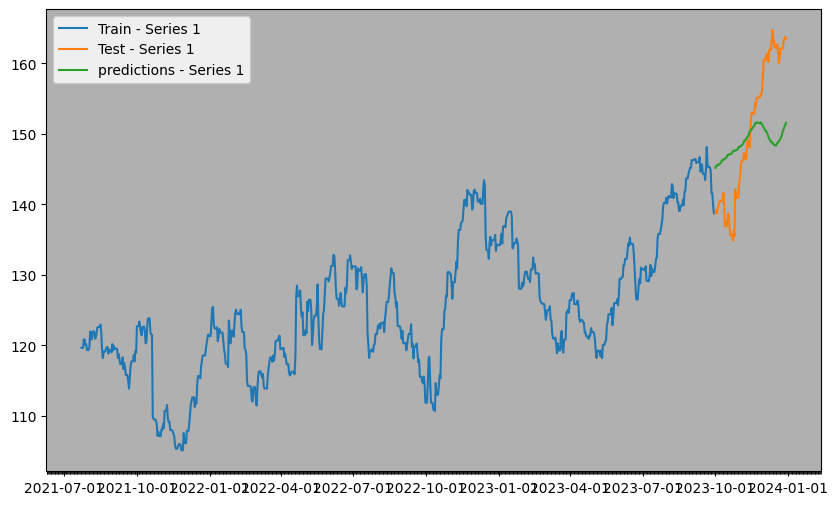

In [395]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(y_train.iloc[-800:].index, y_train.iloc[-800:], label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
plt.plot(y_pred.index, y_pred, label='predictions - Series 1')

# Format x-axis to display dates
ax = plt.gca()
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Add gridlines for each day
ax = plt.gca()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(True, which='both')

plt.legend()
plt.show()

print(y_pred.iloc[0])

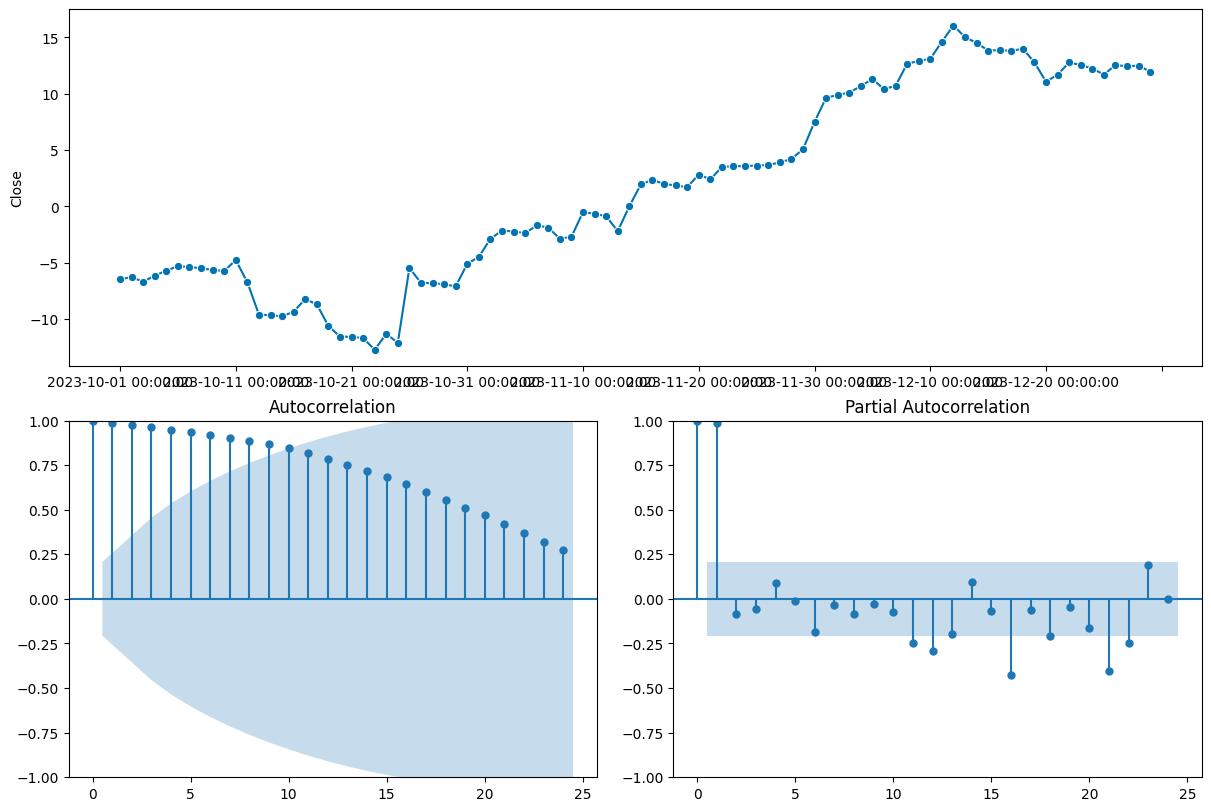

In [396]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()


#### t(1) Prophet

In [126]:
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.base import ForecastingHorizon

# Create a new Prophet object
model = Prophet()

# Fit the model to the data
model.fit(train_transformed)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = model.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

# scores
model_name = 'Prophet_param0_t1'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

13:45:21 - cmdstanpy - INFO - Chain [1] start processing
13:45:21 - cmdstanpy - INFO - Chain [1] done processing


,Model,RMSE,MAE,MAPE
0,Prophet_param0_t1,10.598033,8.732641,0.055728


In [127]:
# error metrics:
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

,Model,RMSE,MAE,MAPE
0,SMA_gscv_win3_t0,15.000758,12.049256,0.076594
1,SMA_gscv_win30_t1,26.394814,21.503861,0.136863
2,SES_gscv_damp0_trend0_s5_t0,14.848146,11.916442,0.075752
3,SES_gscv_damp0_trend0_t0,15.320774,12.332927,0.078400
4,SES_gscv_damp0_trend0_sp365_t0,15.320774,12.332927,0.078400
5,SES_gscv_damp0_trend0_t1,13.510300,10.900504,0.069356
6,SES_gscv_damp0_trend0_sp365_s0_t1,13.510300,10.900504,0.069356
7,SES_gscv_s0_t1,13.510300,10.900504,0.069356
8,Prophet_param0_t0,8.811093,7.643583,0.050422
9,Prophet_param0_t1,10.598033,8.732641,0.055728


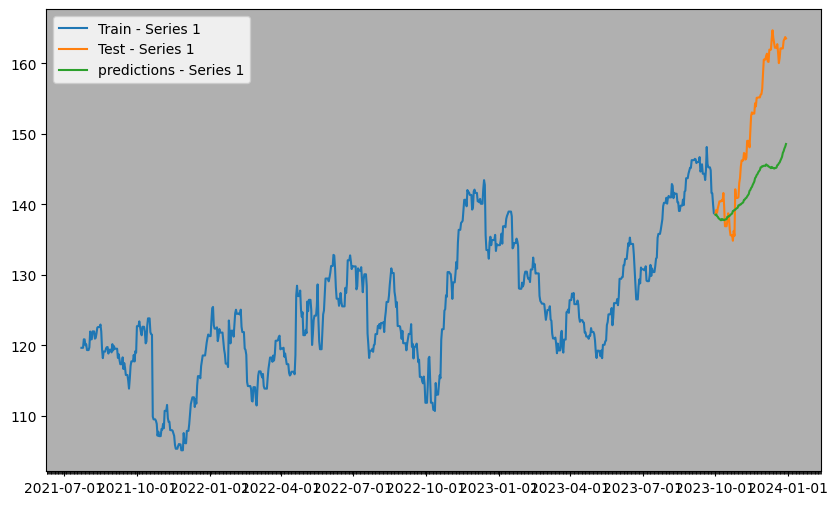

138.52193610679248


In [128]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(y_train.iloc[-800:].index, y_train.iloc[-800:], label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
plt.plot(y_pred.index, y_pred, label='predictions - Series 1')

# Format x-axis to display dates
ax = plt.gca()
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Add gridlines for each day
ax = plt.gca()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(True, which='both')

plt.legend()
plt.show()

print(y_pred.iloc[0])

#### t(1) Prophet * gridsearch WIP

### ARIMA

#### t(0) ARIMA

In [391]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon

# 1,0,0
# 1,1,0
# 1,1,1
# Create a new Prophet object
model = ARIMA(order=(1, 1, 0))

# Fit the model to the data
model.fit(y_train)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = model.predict(fh_n)

# scores
model_name = 'ARIMA_1_1_1_t(0)'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

,Model,RMSE,MAE,MAPE
0,ARIMA_1_1_1_t(0),13.506661,10.897783,0.069339


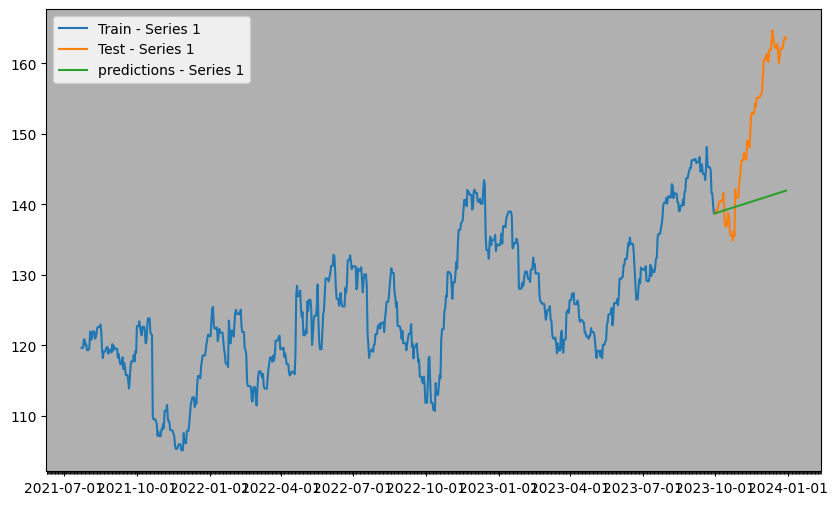

In [392]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(y_train.iloc[-800:].index, y_train.iloc[-800:], label='Train - Series 1')
plt.plot(y_test.index, y_test, label='Test - Series 1')
plt.plot(y_pred.index, y_pred, label='predictions - Series 1')

# Format x-axis to display dates
ax = plt.gca()
date_format = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_format)

# Add gridlines for each day
ax = plt.gca()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.grid(True, which='both')

plt.legend()
plt.show()

print(y_pred.iloc[0])

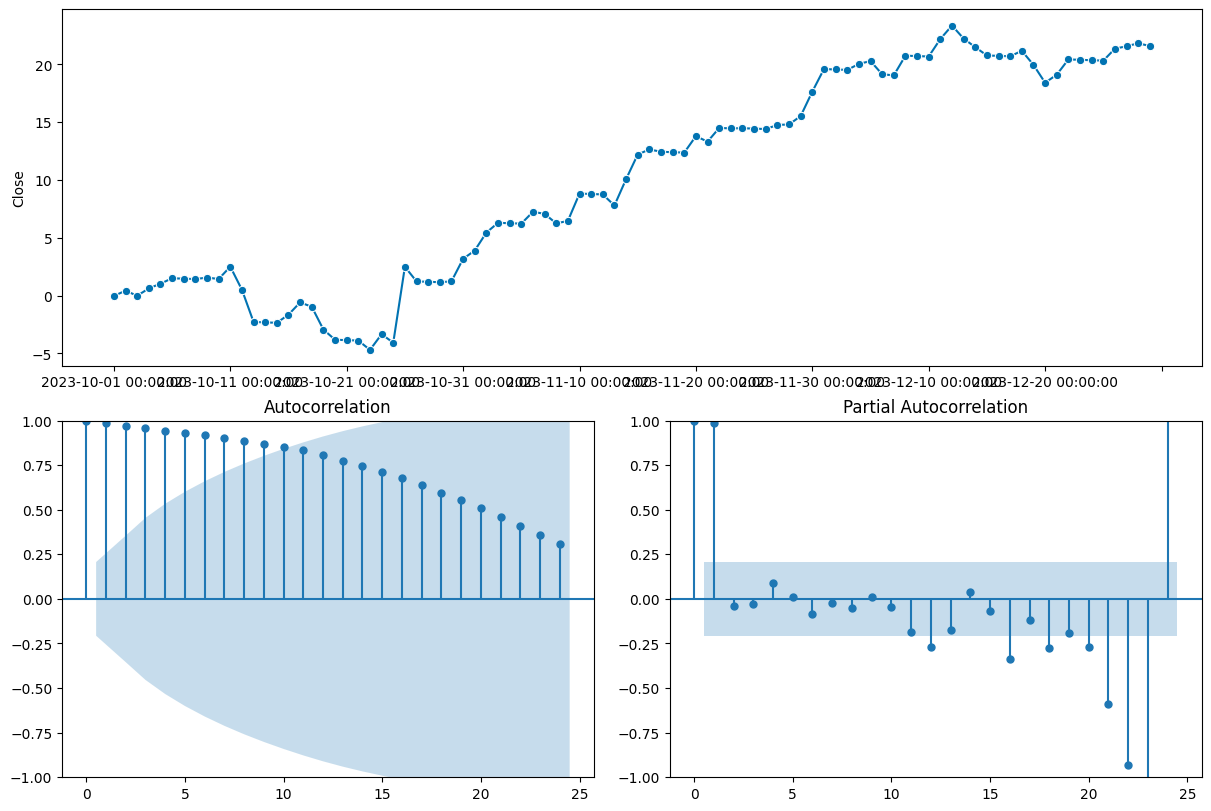

In [393]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()


In [219]:
# error metrics:
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

,Model,RMSE,MAE,MAPE
0,SMA_gscv_win3_t0,15.000758,12.049256,0.076594
1,SMA_gscv_win30_t1,26.394814,21.503861,0.136863
2,SES_gscv_damp0_trend0_s5_t0,14.848146,11.916442,0.075752
3,SES_gscv_damp0_trend0_t0,15.320774,12.332927,0.078400
4,SES_gscv_damp0_trend0_sp365_t0,15.320774,12.332927,0.078400
5,SES_gscv_damp0_trend0_t1,13.510300,10.900504,0.069356
6,SES_gscv_damp0_trend0_sp365_s0_t1,13.510300,10.900504,0.069356
7,SES_gscv_s0_t1,13.510300,10.900504,0.069356
8,Prophet_param0_t0,8.811093,7.643583,0.050422
9,Prophet_param0_t1,10.598033,8.732641,0.055728


In [342]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
from sktime.split import SlidingWindowSplitter

cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

#cv = ExpandingWindowSplitter(
#    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

df = evaluate(forecaster=model, y=y_train, cv=cv, strategy="refit", return_data=True)

#df.iloc[:, :5]
df.describe()

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
count,190.000000,190.000000,190.000000,190.0,190
mean,0.072995,0.006105,0.004355,30.0,2022-05-15 12:00:00
min,0.000116,0.005026,0.003404,30.0,2021-01-28 00:00:00
25%,0.038256,0.005620,0.003429,30.0,2021-09-21 06:00:00
50%,0.063987,0.005887,0.003451,30.0,2022-05-15 12:00:00
75%,0.097678,0.006072,0.003542,30.0,2023-01-06 18:00:00
max,0.237492,0.026303,0.154655,30.0,2023-08-31 00:00:00
std,0.049990,0.001911,0.010970,0.0,NaN


#### t(1) ARIMA

In [234]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon

# 1,0,0
# 1,1,0
# 1,1,1
# Create a new Prophet object
model = ARIMA(order=(2, 0, 0))

# Fit the model to the data
model.fit(train_transformed)

# ;predict
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = model.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

# scores
model_name = 'ARIMA_2_0_0_t(1)'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

,Model,RMSE,MAE,MAPE
0,ARIMA_2_0_0_t(1),13.496555,10.888162,0.069278


In [235]:
# saving error metrics:
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

,Model,RMSE,MAE,MAPE
0,SMA_gscv_win3_t0,15.000758,12.049256,0.076594
1,SMA_gscv_win30_t1,26.394814,21.503861,0.136863
2,SES_gscv_damp0_trend0_s5_t0,14.848146,11.916442,0.075752
3,SES_gscv_damp0_trend0_t0,15.320774,12.332927,0.078400
4,SES_gscv_damp0_trend0_sp365_t0,15.320774,12.332927,0.078400
5,SES_gscv_damp0_trend0_t1,13.510300,10.900504,0.069356
6,SES_gscv_damp0_trend0_sp365_s0_t1,13.510300,10.900504,0.069356
7,SES_gscv_s0_t1,13.510300,10.900504,0.069356
8,Prophet_param0_t0,8.811093,7.643583,0.050422
9,Prophet_param0_t1,10.598033,8.732641,0.055728


In [ ]:
w10 = 1/RMSE_model1
w20 = 1/RMSE_model2
w30 = 1/RMSE_model3
w1 = w10/(w10 + w20 + w30)
w2 = w20/(w10 + w20 + w30)
w3 = w30/(w10 + w20 + w30)
combined_model = (w1 * model1.predict()) + (w2 * model2.predict()) + (w3 * model3.predit())

#### t(0) autoARIMA

In [286]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from matplotlib import pyplot

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

# create model
model_autoarima = AutoARIMA(start_p=1, max_p=10, sp=1, seasonal=False, suppress_warnings=True)

# fit model
model_autoarima.fit(y_train)
y_pred = model_autoarima.predict(fh_n)

# scores
model_name = 'autoARIMA_p1_10_sp1_t(0)'

error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result


,Model,RMSE,MAE,MAPE
0,autoARIMA_p1_10_sp1_t(0),15.31744,12.329825,0.078381


In [250]:
# saving error metrics:
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

,Model,RMSE,MAE,MAPE
0,SMA_gscv_win3_t0,15.000758,12.049256,0.076594
1,SMA_gscv_win30_t1,26.394814,21.503861,0.136863
2,SES_gscv_damp0_trend0_s5_t0,14.848146,11.916442,0.075752
3,SES_gscv_damp0_trend0_t0,15.320774,12.332927,0.078400
4,SES_gscv_damp0_trend0_sp365_t0,15.320774,12.332927,0.078400
5,SES_gscv_damp0_trend0_t1,13.510300,10.900504,0.069356
6,SES_gscv_damp0_trend0_sp365_s0_t1,13.510300,10.900504,0.069356
7,SES_gscv_s0_t1,13.510300,10.900504,0.069356
8,Prophet_param0_t0,8.811093,7.643583,0.050422
9,Prophet_param0_t1,10.598033,8.732641,0.055728


In [251]:
# summary of fit model
print(model_autoarima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1005
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1733.150
Date:                Tue, 30 Jan 2024   AIC                           3470.300
Time:                        16:21:26   BIC                           3480.124
Sample:                    12-30-2020   HQIC                          3474.033
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0611      0.029      2.085      0.037       0.004       0.118
sigma2         1.8489      0.030     61.565      0.000       1.790       1.908
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [318]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError
from sktime.split import SlidingWindowSplitter

cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

#cv = ExpandingWindowSplitter(
#    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

# Create instances of the MeanAbsoluteErrr and MeanSquaredError classes
rmse = MeanSquaredError(square_root=True)
mae = MeanAbsoluteError()
mse = MeanSquaredError()
#mae
df = evaluate(forecaster=model_autoarima, y=y_train, cv=cv, scoring=[rmse], strategy="refit", return_data=True)

df.iloc[:, :]


,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,4.016229,0.173931,0.017617,30,2021-01-28,2020-12-30 102.727783 2020-12-31 104.000...,"2021-02-27 99.571129 Freq: D, Name: Close, ...","2021-02-27 103.587358 Name: Close, dtype: f..."
1,1.879585,0.074121,0.003458,30,2021-02-02,2021-01-04 102.397301 2021-01-05 104.214...,"2021-03-04 100.559052 Freq: D, Name: Close,...","2021-03-04 98.679466 Name: Close, dtype: fl..."
2,3.345535,0.067139,0.003281,30,2021-02-07,2021-01-09 106.189507 2021-01-10 106.189...,"2021-03-09 103.966553 Freq: D, Name: Close,...","2021-03-09 100.621017 Name: Close, dtype: f..."
3,5.701508,0.076985,0.003284,30,2021-02-12,2021-01-14 106.553001 2021-01-15 106.073...,"2021-03-14 106.838242 Freq: D, Name: Close,...","2021-03-14 101.136734 Name: Close, dtype: f..."
4,6.804465,0.139774,0.003601,30,2021-02-17,2021-01-19 106.594322 2021-01-20 107.470...,"2021-03-19 107.918243 Freq: D, Name: Close,...","2021-03-19 101.113778 Name: Close, dtype: f..."
...,...,...,...,...,...,...,...,...
185,6.460114,0.066843,0.003636,30,2023-08-11,2023-07-13 130.911728 2023-07-14 130.403...,"2023-09-10 146.023911 Freq: D, Name: Close,...","2023-09-10 152.484025 Name: Close, dtype: f..."
186,14.405438,0.238468,0.003338,30,2023-08-16,2023-07-18 132.319382 2023-07-19 132.436...,"2023-09-15 144.352875 Freq: D, Name: Close,...","2023-09-15 129.947437 Name: Close, dtype: f..."
187,8.611446,0.180468,0.003874,30,2023-08-21,2023-07-23 135.818954 2023-07-24 136.405...,"2023-09-20 148.149811 Freq: D, Name: Close,...","2023-09-20 139.538364 Name: Close, dtype: f..."
188,3.648942,0.102677,0.003606,30,2023-08-26,2023-07-28 140.227646 2023-07-29 140.227...,"2023-09-25 144.837372 Freq: D, Name: Close,...","2023-09-25 141.18843 Name: Close, dtype: fl..."


In [319]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanSquaredError
from sktime.split import SlidingWindowSplitter

#cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

cv = ExpandingWindowSplitter(
    step_length=5, fh=[30], initial_window=72)

# Create instances of the MeanAbsoluteErrr and MeanSquaredError classes
rmse = MeanSquaredError(square_root=True)
mae = MeanAbsoluteError()
mse = MeanSquaredError()
#mae
df = evaluate(forecaster=model_autoarima, y=y_train, cv=cv, scoring=[rmse], strategy="refit", return_data=True)

df.iloc[:, :]


,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,7.191757,0.071021,0.006077,72,2021-03-11,2020-12-30 102.727783 2020-12-31 104.000...,"2021-04-10 113.636497 Freq: D, Name: Close,...","2021-04-10 106.44474 Name: Close, dtype: fl..."
1,7.936128,0.123608,0.003843,77,2021-03-16,2020-12-30 102.727783 2020-12-31 104.000...,"2021-04-15 110.999252 Freq: D, Name: Close,...","2021-04-15 103.063124 Name: Close, dtype: f..."
2,12.226868,0.149779,0.004181,82,2021-03-21,2020-12-30 102.727783 2020-12-31 104.000...,"2021-04-20 115.670952 Freq: D, Name: Close,...","2021-04-20 103.444084 Name: Close, dtype: f..."
3,5.065193,0.052249,0.003355,87,2021-03-26,2020-12-30 102.727783 2020-12-31 104.000...,"2021-04-25 119.245911 Freq: D, Name: Close,...","2021-04-25 114.180717 Name: Close, dtype: f..."
4,7.216873,0.054850,0.003289,92,2021-03-31,2020-12-30 102.727783 2020-12-31 104.000...,"2021-04-30 118.785431 Freq: D, Name: Close,...","2021-04-30 111.568558 Name: Close, dtype: f..."
...,...,...,...,...,...,...,...,...
176,3.258831,0.392314,0.003728,952,2023-08-08,2020-12-30 102.727783 2020-12-31 104.000...,"2023-09-07 145.865723 Freq: D, Name: Close,...","2023-09-07 142.606892 Name: Close, dtype: f..."
177,3.144384,0.244051,0.003475,957,2023-08-13,2020-12-30 102.727783 2020-12-31 104.000...,"2023-09-12 144.659393 Freq: D, Name: Close,...","2023-09-12 141.515009 Name: Close, dtype: f..."
178,4.480779,0.276555,0.003952,962,2023-08-18,2020-12-30 102.727783 2020-12-31 104.000...,"2023-09-17 144.352875 Freq: D, Name: Close,...","2023-09-17 139.872096 Name: Close, dtype: f..."
179,3.336432,0.240258,0.003499,967,2023-08-23,2020-12-30 102.727783 2020-12-31 104.000...,"2023-09-22 145.262558 Freq: D, Name: Close,...","2023-09-22 141.926126 Name: Close, dtype: f..."


#### t(1) autoARIMA

In [277]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from matplotlib import pyplot

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

# create model
model_autoarima = AutoARIMA(start_p=1, max_p=10, sp=1, seasonal=False, suppress_warnings=True)

# fit model
model_autoarima.fit(train_transformed)
y_pred_transformed = model.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

# scores
model_name = 'autoARIMA_p1_10_sp1_t(1)'

error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

,Model,RMSE,MAE,MAPE
0,autoARIMA_p1_10_sp1_t(1),13.496555,10.888162,0.069278


In [254]:
# saving error metrics:
model_scoring = pd.concat([model_scoring, error_metrics_result], ignore_index=True)
model_scoring

,Model,RMSE,MAE,MAPE
0,SMA_gscv_win3_t0,15.000758,12.049256,0.076594
1,SMA_gscv_win30_t1,26.394814,21.503861,0.136863
2,SES_gscv_damp0_trend0_s5_t0,14.848146,11.916442,0.075752
3,SES_gscv_damp0_trend0_t0,15.320774,12.332927,0.078400
4,SES_gscv_damp0_trend0_sp365_t0,15.320774,12.332927,0.078400
5,SES_gscv_damp0_trend0_t1,13.510300,10.900504,0.069356
6,SES_gscv_damp0_trend0_sp365_s0_t1,13.510300,10.900504,0.069356
7,SES_gscv_s0_t1,13.510300,10.900504,0.069356
8,Prophet_param0_t0,8.811093,7.643583,0.050422
9,Prophet_param0_t1,10.598033,8.732641,0.055728


In [278]:
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
from sktime.split import SlidingWindowSplitter

cv = SlidingWindowSplitter(fh = [30], window_length = 30, step_length = 5)

#cv = ExpandingWindowSplitter(
#    step_length=12, fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], initial_window=72)

df = evaluate(forecaster=model_autoarima, y=y_train, cv=cv, strategy="refit", return_data=True)

df.iloc[:, :5]

/Users/alexferrer/Desktop/bootcamp/Week_9/Final_project/project_env/lib/python3.11/site-packages/pmdarima/arima/_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,0,0)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.040335,0.154165,0.004020,30,2021-01-28
1,0.018691,0.071183,0.003412,30,2021-02-02
2,0.032179,0.067058,0.003280,30,2021-02-07
3,0.053366,0.076451,0.003270,30,2021-02-12
4,0.063052,0.140477,0.003610,30,2021-02-17
...,...,...,...,...,...
185,0.044240,0.066682,0.003512,30,2023-08-11
186,0.099793,0.239436,0.003268,30,2023-08-16
187,0.058127,0.175542,0.003698,30,2023-08-21
188,0.025193,0.102801,0.003508,30,2023-08-26


## Models building part ii: Reduction: from forecasting to regression

### GradientBoost

#### t(0)

In [170]:
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)
#RecursiveTabularRegressionForecaster(...)
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = forecaster.predict(fh_n)

# scores
model_name = 'reg_gradientboostin_param0_t(0)'

error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

,Model,RMSE,MAE,MAPE
0,reg_gradientboostin_param0_t(0),15.331065,12.350915,0.078522


#### t(1)

In [320]:
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

forecaster.fit(train_transformed)

#RecursiveTabularRegressionForecaster(...)
fh_n = ForecastingHorizon(y_test.index, is_relative=False)

y_pred_transformed = forecaster.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)
# scores
model_name = 'reg_gradientboostin_param0_t(1)'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

,Model,RMSE,MAE,MAPE
0,reg_gradientboostin_param0_t(1),13.793493,11.23313,0.071559


### KNeighborsRegressor

#### t(0)

,Model,RMSE,MAE,MAPE
0,reg_knn_n1_t(0),13.82451,11.072884,0.070471


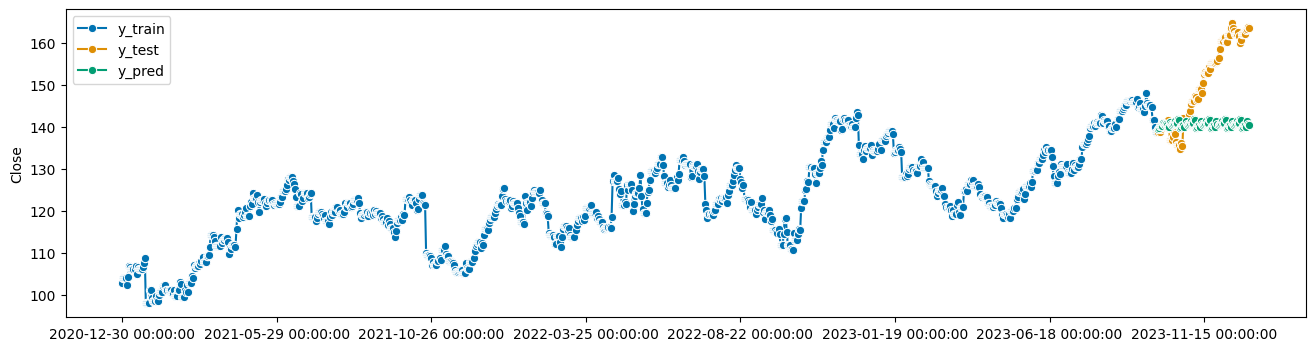

In [425]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series

regressor = KNeighborsRegressor(n_neighbors=2)
forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh_n)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
#mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

# scores
model_name = 'reg_knn_n1_t(0)'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

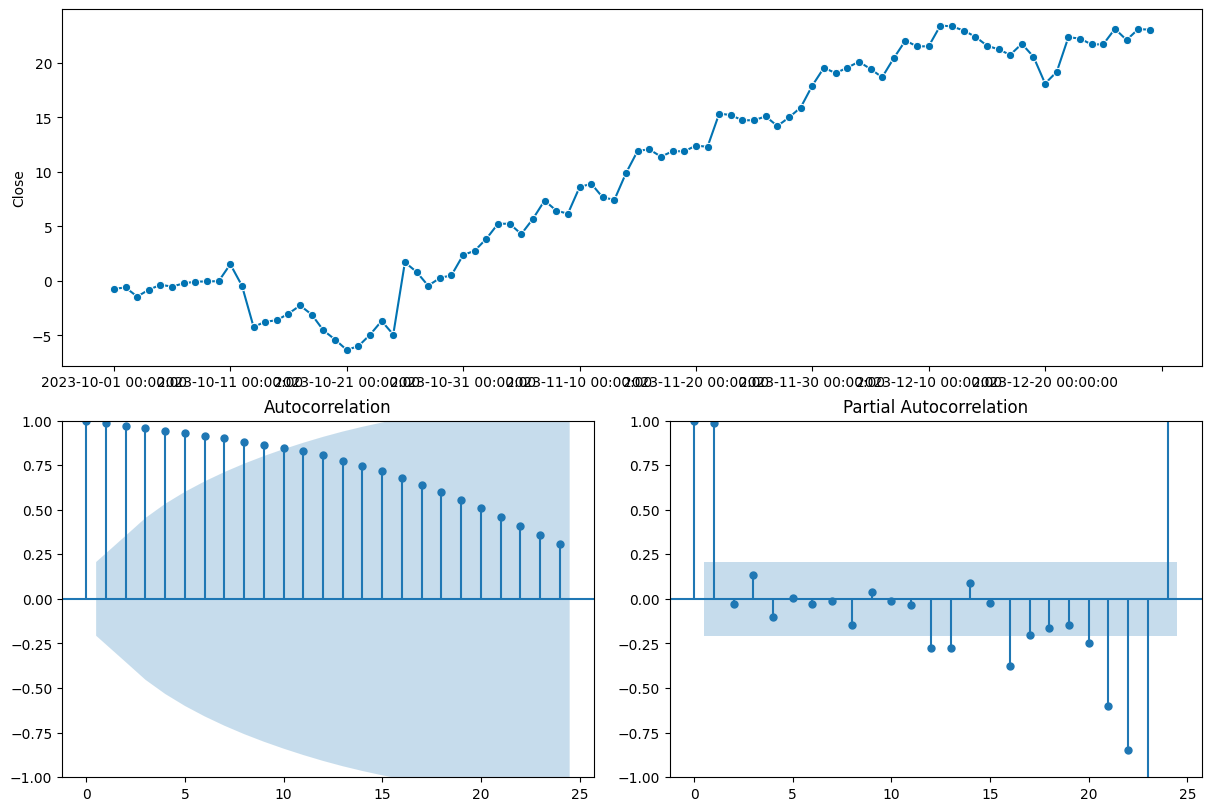

In [426]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
fig, ax = plot_correlations(residuals)
plt.show()


#### t(1)

,Model,RMSE,MAE,MAPE
0,reg_gradientboostin_param0_t(1),20.768039,15.494928,0.097782


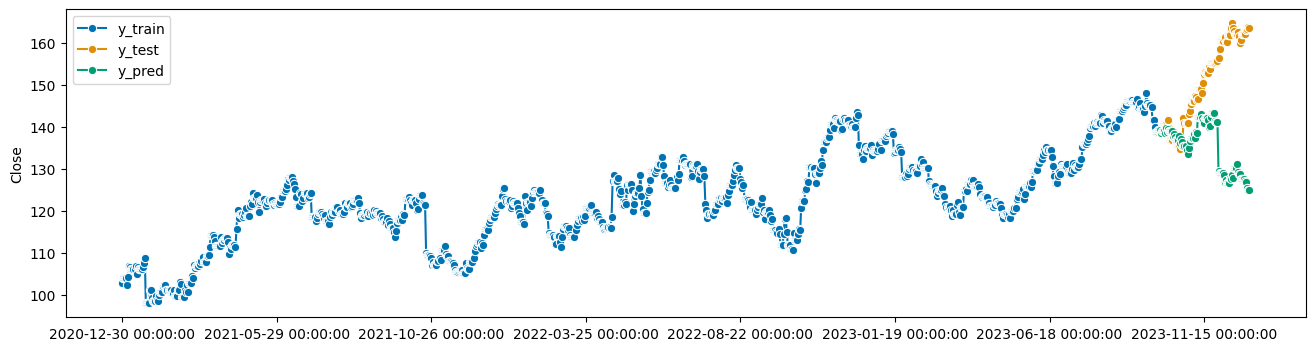

In [325]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=45, strategy="recursive")

fh_n = ForecastingHorizon(y_test.index, is_relative=False)

forecaster.fit(train_transformed)

y_pred_transformed = forecaster.predict(fh_n)
y_pred = differencer.inverse_transform(y_pred_transformed)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# scores
model_name = 'reg_gradientboostin_param0_t(1)'
error_metrics_result = calculate_error_metrics(model_name, y_test, y_pred)
error_metrics_result

## Models: Bootstrap * ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

# Load your stock price data into a pandas DataFrame
# Assuming 'stock_data' has a 'closing_price' column
# Replace 'your_data.csv' with the actual file or data source

stock_data = pd.read_csv('your_data.csv')

# Define a function to fit ARIMA and return the prediction
def fit_arima(data):
    model = ARIMA(data, order=(1, 1, 0))  # Set appropriate p, d, q values
    fitted_model = model.fit()
    forecast = fitted_model.predict(start=len(data), end=len(data) + forecast_horizon - 1, typ='levels')
    return forecast
# Number of bootstrap samples
num_samples = 1000
# Number of days to forecast
forecast_horizon = 5
# Initialize an array to store bootstrap sample MSEs
bootstrap_mses = []

# Perform bootstrapping
for _ in range(num_samples):
    # Resample the data with replacement
    resampled_data = resample(stock_data['closing_price'].values)
    # Fit ARIMA on the resampled data
    forecast = fit_arima(resampled_data)
    # Evaluate the model's performance (e.g., using Mean Squared Error)
    true_values = stock_data['closing_price'].tail(forecast_horizon).values
    mse = mean_squared_error(true_values, forecast)
    # Store the MSE for this bootstrap sample
    bootstrap_mses.append(mse)
# Calculate the mean and confidence interval of the MSEs
mean_mse = np.mean(bootstrap_mses)
confidence_interval = np.percentile(bootstrap_mses, [2.5, 97.5])
print("Mean MSE:", mean_mse)
print("95% Confidence Interval:", confidence_interval)